# ML Project Team SBB - Detailed description on the Word embeddings

## Processing

### Google Collab setting

To check if we are using teh high-RAM from Collab Pro and if we are connected to high GPU

In order to use a GPU with your notebook, select the <code>Runtime &gt; Change runtime type</code> menu, and then set the hardware accelerator drop-down to GPU.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon May 13 19:19:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


### Installing the packages

In [1]:
!pip install datasets transformers huggingface_hub
!apt-get install git-lfs
!pip install transformers[torch]
!pip install accelerate -U
!pip install spacy
!pip install gensim
!pip install xgboost
!python -m spacy download fr_core_news_sm
!pip install sacremoses
!pip install plotly
!pip install evaluate

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 0 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 37.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Standard library imports
import multiprocessing
import os
import re
import random

# Data handling and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             precision_recall_fscore_support, cosine_similarity)
from sklearn.model_selection import GridSearchCV, train_test_split, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# XGBoost for advanced modeling
from xgboost import XGBClassifier

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
from gensim.models import Word2Vec

# PyTorch for deep learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset, Subset

# Hugging Face Transformers
from transformers import (AdamW, AutoModelForSequenceClassification, BertConfig, BertTokenizer,
                          FlaubertModel, FlaubertTokenizer, FlaubertForSequenceClassification,
                          CamembertTokenizer, CamembertForSequenceClassification,
                          get_linear_schedule_with_warmup, Trainer, TrainingArguments)

# Google Colab tools (optional, uncomment if needed)
# from google.colab import files

# NLTK data download
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# spaCy model load
nlp = spacy.load('en_core_web_sm')

# Check CUDA availability for PyTorch
cuda_available = torch.cuda.is_available()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Downloading the data

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/AnyaLang/SBB_ML/7579dbb73a4fda0126be80c6c1bdd31eee02e9f0/training_data.csv')
df.head()

HTTPError: HTTP Error 404: Not Found

In [ ]:
df["difficulty"].unique()

In [ ]:
our_predictions = pd.read_csv('https://raw.githubusercontent.com/AnyaLang/SBB_ML/7579dbb73a4fda0126be80c6c1bdd31eee02e9f0/unlabelled_test_data.csv')
our_predictions.head()

## Training of the model

### FlauBERT

For our training, we are using the FlauBERT model from [Hugging Face](https://huggingface.co/docs/transformers/en/model_doc/flaubert), as described:

> The FlauBERT model was proposed in the paper FlauBERT: Unsupervised Language Model Pre-training for French by Hang Le et al. It’s a transformer model pretrained using a masked language modeling (MLM) objective (like BERT).

For the FlauBERT model, one can choose from several options:

| Model name                | Number of layers | Attention Heads | Embedding Dimension | Total Parameters |
|---------------------------|------------------|-----------------|---------------------|------------------|
| flaubert-small-cased      | 6                | 8               | 512                 | 54M              |
| flaubert-base-uncased     | 12               | 12              | 768                 | 137M             |
| flaubert-base-cased       | 12               | 12              | 768                 | 138M             |
| flaubert-large-cased      | 24               | 16              | 1024                | 373M             |


We will use the FlauBERT large cased model because it has greater depth, a more sophisticated attention mechanism, a larger embedding size, and a higher parameter count. Larger models such as the FlauBERT large cased typically outperform smaller ones across a variety of language understanding benchmarks, potentially offering higher accuracy.

##### **Model with different learning rates**

Important to note that our first model is trained using the AdamW optimizer, which is a variant of the traditional Adam optimizer. AdamW incorporates a regularization technique known as [weight decay](https://github.com/tml-epfl/why-weight-decay), which is used in training neural networks to prevent overfitting. It functions by incorporating a term into the loss function that penalizes large weights.

Besides, we also employ a Linear Learning Rate Scheduler to manage the learning rate throughout the training process. This scheduler starts with a relatively high learning rate and gradually decreases it to near zero by the end of the training. This approach ensures that we begin training with aggressive learning steps and fine-tune the model parameters more delicately as training progresses.

Although this training setup does not include a warm-up phase where the learning rate would gradually ramp up before decreasing, the scheduler is configured to reduce the learning rate slightly with each training step. This gradual reduction helps in stabilizing the training as it advances.

We would like to first observe the results with this setup and may adjust these parameters further based on the outcomes of the initial training phase.

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Load tokenizer
model_french = 'flaubert/flaubert_large_cased'
tokenizer = FlaubertTokenizer.from_pretrained(model_french, do_lowercase=False)

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

# Training and evaluation function
def train_and_evaluate(model, train_dataset, val_dataset, learning_rate, num_epochs, train_batch_size, eval_batch_size):
    set_seed(42)
    optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=(len(train_dataset) // train_batch_size) * num_epochs)

    best_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        average_loss = total_loss / len(train_dataset)
        accuracy, precision, recall, f1 = evaluate(model, val_dataset, eval_batch_size)
        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate {learning_rate}, Average Loss: {average_loss}")
        print(f"Validation Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            model_filename = f'best_model_lr{learning_rate}_ep{epoch+1}_acc{best_accuracy:.2f}.pt'
            torch.save(model.state_dict(), model_filename)
            print(f"Saved improved model as {model_filename} with accuracy: {best_accuracy:.2f}")

    return average_loss, best_accuracy

# Data preparation and training
tokenized_data = tokenize_data(df['sentence'].tolist())
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Prepare data
tokenized_data = tokenize_data(df['sentence'].tolist())
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))

# Splitting the dataset into training and testing sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)

# Tokenize train and validation texts
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())

# Creating datasets for train and validation
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Parameters
learning_rates = [1e-4, 5e-5, 3e-5, 2e-5]
learning_rates = [1e-4, 5e-5, 3e-5, 2e-5]
num_epochs = 4
train_batch_sizes = [16, 32]  # Included specified batch sizes
eval_batch_sizes = [16, 32]   # Use the same specified batch sizes for evaluation for consistency

# Hyperparameter tuning
results = []
for train_batch_size in train_batch_sizes:
    for eval_batch_size in eval_batch_sizes:
        for lr in learning_rates:
            print(f"Training with learning rate: {lr}, train batch size: {train_batch_size}, eval batch size: {eval_batch_size}")
            model = FlaubertForSequenceClassification.from_pretrained(model_french, num_labels=len(label_encoder.classes_)).to(device)
            # Update the function call to include eval_batch_size
            loss, accuracy = train_and_evaluate(model, train_dataset, val_dataset, lr, num_epochs, train_batch_size, eval_batch_size)
            results.append((train_batch_size, eval_batch_size, lr, loss, accuracy))

# Selecting the best model based on accuracy
best_result = max(results, key=lambda x: x[2])
print(f"Best Learning Rate: {best_result[0]} with Loss: {best_result[1]} and Accuracy: {best_result[2]}")

**Results of the training on the batch of 16 with different learning rates**

| Learning Rate | Epoch | Average Loss | Accuracy   | Precision | Recall    | F1 Score  | Notes                  |
|---------------|-------|--------------|------------|-----------|-----------|-----------|------------------------|
| 0.0001        | 1     | 0.15489      | 22.71%     | 18.81%    | 22.71%    | 12.83%    | -                      |
| 0.0001        | 2     | 0.10375      | 37.92%     | 46.40%    | 37.92%    | 32.24%    | -                      |
| 0.0001        | 3     | 0.09681      | 45.62%     | 52.56%    | 45.62%    | 42.65%    | -                      |
| 0.0001        | 4     | 0.07292      | 51.15%     | 50.92%    | 51.15%    | 50.50%    | -                      |
| 5e-05         | 1     | 0.10961      | 42.92%     | 39.80%    | 42.92%    | 39.47%    | -                      |
| 5e-05         | 2     | 0.08257      | 50.42%     | 53.07%    | 50.42%    | 48.79%    | -                      |
| 5e-05         | 3     | 0.06633      | 55.31%     | 57.52%    | 55.31%    | 54.84%    | -                      |
| 5e-05         | 4     | 0.05221      | 56.98%     | 57.05%    | 56.98%    | 56.76%    | Best overall performance |
| 3e-05         | 1     | 0.10324      | 44.58%     | 52.58%    | 44.58%    | 42.50%    | -                      |
| 3e-05         | 2     | 0.07793      | 48.96%     | 49.55%    | 48.96%    | 46.42%    | -                      |
| 3e-05         | 3     | 0.06602      | 55.62%     | 56.60%    | 55.62%    | 55.01%    | -                      |
| 3e-05         | 4     | 0.05735      | 55.94%     | 55.52%    | 55.94%    | 55.39%    | -                      |
| 2e-05         | 1     | 0.10434      | 44.90%     | 50.87%    | 44.90%    | 42.50%    | -                      |
| 2e-05         | 2     | 0.07980      | 49.58%     | 50.54%    | 49.58%    | 48.43%    | -                      |
| 2e-05         | 3     | 0.06963      | 53.44%     | 53.24%    | 53.44%    | 52.64%    | -                      |
| 2e-05         | 4     | 0.06303      | 52.71%     | 52.48%    | 52.71%    | 52.28%    | -                      |


Our training was interrupted, so we couldn't fully evaluate the results for a batch size of 32. However, from what we observed, a learning rate of 5e-05 yielded the highest performance in terms of accuracy, precision, recall, and F1 score. In the next stage, we will continue training our model using this learning rate and adjust the batch size to fully assess the results for batch 32.



---



**Comparison of the model with batch 32 and 16 for the learning rate 5e-05**

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    random.seed(worker_seed)
    np.random.seed(worker_seed)

# Set seed early in the script
set_seed(42)


# Load tokenizer
model_french = 'flaubert/flaubert_large_cased'
tokenizer = FlaubertTokenizer.from_pretrained(model_french, do_lowercase=False)

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

# Training and evaluation function
def train_and_evaluate(model, train_dataset, val_dataset, num_epochs, train_batch_size):
    set_seed(42)
    optimizer = AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.999), eps=1e-08)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=(len(train_dataset) // train_batch_size) * num_epochs)

    best_f1 = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        average_loss = total_loss / len(train_dataset)
        accuracy, precision, recall, f1 = evaluate(model, val_dataset, train_batch_size)
        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate 5e-5, Average Loss: {average_loss}")
        print(f"Validation Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

        if f1 > best_f1:  # Considering F1 score for model saving
            best_f1 = f1
            model_filename = f'best_model_f1{best_f1:.2f}_epoch{epoch+1}.pt'
            torch.save(model.state_dict(), model_filename)
            print(f"Saved improved model as {model_filename} with F1 Score: {best_f1:.2f}")

    return average_loss, best_f1

# Data preparation
tokenized_data = tokenize_data(df['sentence'].tolist())
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Training model
model = FlaubertForSequenceClassification.from_pretrained(model_french, num_labels=len(label_encoder.classes_)).to(device)
train_and_evaluate(model, train_dataset, val_dataset, num_epochs=4, train_batch_size=32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/896k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_large_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4, Learning Rate 5e-5, Average Loss: 0.05303378058597445
Validation Metrics - Accuracy: 0.43125, Precision: 0.5486596480825454, Recall: 0.43125, F1 Score: 0.4053166421297725
Saved improved model as best_model_f10.41_epoch1.pt with F1 Score: 0.41
Epoch 2/4, Learning Rate 5e-5, Average Loss: 0.04004011674163242
Validation Metrics - Accuracy: 0.4791666666666667, Precision: 0.5172350206999379, Recall: 0.4791666666666667, F1 Score: 0.47423646141347736
Saved improved model as best_model_f10.47_epoch2.pt with F1 Score: 0.47
Epoch 3/4, Learning Rate 5e-5, Average Loss: 0.03195396222484608
Validation Metrics - Accuracy: 0.5510416666666667, Precision: 0.5744112146385306, Recall: 0.5510416666666667, F1 Score: 0.547718278630853
Saved improved model as best_model_f10.55_epoch3.pt with F1 Score: 0.55
Epoch 4/4, Learning Rate 5e-5, Average Loss: 0.02597418347528825
Validation Metrics - Accuracy: 0.5739583333333333, Precision: 0.5810352272715067, Recall: 0.5739583333333333, F1 Score: 0.5750710

(0.02597418347528825, 0.575071069020113)

We further trained the model on the batch size 32 over 4 epochs with the learning rate 5e-05. These are the results that we got:

| Epoch | Learning Rate | Average Loss     | Accuracy   | Precision | Recall   | F1 Score  |
|-------|---------------|------------------|------------|-----------|----------|-----------|
| 1/4   | 5e-5          | 0.053033780585974| 0.43125    | 0.5486596 | 0.43125  | 0.4053166 |
| 2/4   | 5e-5          | 0.040040116741632| 0.4791667  | 0.5172350 | 0.4791667| 0.4742365 |
| 3/4   | 5e-5          | 0.031953962224846| 0.5510417  | 0.5744112 | 0.5510417| 0.5477183 |
| 4/4   | 5e-5          | 0.025974183475288| 0.5739583  | 0.5810352 | 0.5739583| 0.5750711 |

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Load tokenizer
model_french = 'flaubert/flaubert_large_cased'
tokenizer = FlaubertTokenizer.from_pretrained(model_french, do_lowercase=False)

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    loss_fct = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            loss = loss_fct(logits, batch['labels'])
            total_loss += loss.item()
            pred_labels = torch.argmax(logits, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    val_loss = total_loss / len(dataset)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
    conf_matrix = confusion_matrix(true_labels, predictions)
    class_report = classification_report(true_labels, predictions)
    return val_loss, accuracy, precision, recall, f1, conf_matrix, class_report

# Training and evaluation function
def train_and_evaluate(model, train_dataset, val_dataset, num_epochs, train_batch_size):
    set_seed(42)
    optimizer = AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.999), eps=1e-08)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=(len(train_dataset) // train_batch_size) * num_epochs)

    best_f1 = 0
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_dataset)
        val_loss, accuracy, precision, recall, f1, conf_matrix, class_report = evaluate(model, val_dataset, train_batch_size)
        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate 5e-5, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Validation Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
        print("Confusion Matrix:\n", conf_matrix)
        print("Classification Report:\n", class_report)

        if f1 > best_f1:
            best_f1 = f1
            model_filename = f'best_model_f1{best_f1:.2f}_epoch{epoch+1}.pt'
            torch.save(model.state_dict(), model_filename)
            print(f"Saved improved model as {model_filename} with F1 Score: {best_f1:.2f}")

    return train_loss, val_loss, best_f1

# Example of data preparation and training model
# Assuming df is defined and contains text and label columns 'sentence' and 'difficulty'
tokenized_data = tokenize_data(df['sentence'].tolist())
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

model = FlaubertForSequenceClassification.from_pretrained(model_french, num_labels=len(label_encoder.classes_)).to(device)
train_and_evaluate(model, train_dataset, val_dataset, num_epochs=4, train_batch_size=32)

In [ ]:
data_16 = {
    'Epoch': [1, 2, 3, 4],
    'Average Loss': [0.109613778643931, 0.082573650358245, 0.066333369088049, 0.052208390032562],
    'Accuracy': [0.4291667, 0.5041667, 0.553125, 0.5697917],
    'F1 Score': [0.3946793, 0.4878596, 0.5484398, 0.5675771]
}

data_32 = {
    'Epoch': [1, 2, 3, 4],
    'Average Loss': [0.053033780585974, 0.040040116741632, 0.031953962224846, 0.025974183475288],
    'Accuracy': [0.43125, 0.4791667, 0.5510417, 0.5739583],
    'F1 Score': [0.4053166, 0.4742365, 0.5477183, 0.5750711]
}

df16 = pd.DataFrame(data_16)
df32 = pd.DataFrame(data_32)

# Create traces for Batch Size 16 and 32
traces = []
for label, color, df in [('Batch Size 16', 'blue', df16), ('Batch Size 32', 'orange', df32)]:
    traces.append(go.Scatter(x=df['Epoch'], y=df['Average Loss'], mode='lines+markers',
                             name=f'Average Loss {label}', marker=dict(color=color)))
    traces.append(go.Scatter(x=df['Epoch'], y=df['Accuracy'], mode='lines+markers',
                             name=f'Accuracy {label}', marker=dict(color=color)))
    traces.append(go.Scatter(x=df['Epoch'], y=df['F1 Score'], mode='lines+markers',
                             name=f'F1 Score {label}', marker=dict(color=color)))

# Create the figure
fig = go.Figure()

# Add all traces to the figure
for trace in traces:
    fig.add_trace(trace)

# Set layout for the first view (Average Loss)
fig.update_layout(
    title='Model Performance Comparison by Batch Size',
    xaxis_title='Epoch',
    yaxis_title='Average Loss',
    legend_title='Metric by Batch Size',
    template='plotly_white',
    hovermode='x unified'
)

# Add buttons to toggle between metrics
fig.update_layout(
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            active=0,
            x=0.7,
            y=1.15,
            buttons=list([
                dict(label="Average Loss",
                     method="update",
                     args=[{"visible": [True, False, False, True, False, False]},
                           {"yaxis": {"title": "Average Loss"}}]),
                dict(label="Accuracy",
                     method="update",
                     args=[{"visible": [False, True, False, False, True, False]},
                           {"yaxis": {"title": "Accuracy"}}]),
                dict(label="F1 Score",
                     method="update",
                     args=[{"visible": [False, False, True, False, False, True]},
                           {"yaxis": {"title": "F1 Score"}}])
            ]),
        )
    ])

# Show the figure
fig.show()

From the graph, it's clear that the **average loss for the batch size of 32 is significantly lower than that for the batch size of 16 at every epoch.**

##### **Training model with the chosen learning rate 5e-05 with batch 32**

We decided to train the model over a larger number of epochs, in this case 6 with the batch 32 and the same learning rate as before.

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Load tokenizer
model_french = 'flaubert/flaubert_large_cased'
tokenizer = FlaubertTokenizer.from_pretrained(model_french, do_lowercase=False)

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    loss_fct = torch.nn.CrossEntropyLoss()
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            loss = loss_fct(logits, batch['labels'])
            total_loss += loss.item()
            pred_labels = torch.argmax(logits, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    val_loss = total_loss / len(dataset)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
    conf_matrix = confusion_matrix(true_labels, predictions)
    class_report = classification_report(true_labels, predictions)
    return val_loss, accuracy, precision, recall, f1, conf_matrix, class_report

# Training and evaluation function
def train_and_evaluate(model, train_dataset, val_dataset, num_epochs, train_batch_size):
    set_seed(42)
    optimizer = AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.999), eps=1e-08)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=(len(train_dataset) // train_batch_size) * num_epochs)

    best_f1 = 0
    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_train_loss += loss.item()

        train_loss = total_train_loss / len(train_dataset)
        val_loss, accuracy, precision, recall, f1, conf_matrix, class_report = evaluate(model, val_dataset, train_batch_size)
        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate 5e-5, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Validation Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
        print("Confusion Matrix:\n", conf_matrix)
        print("Classification Report:\n", class_report)

        if f1 > best_f1:
            best_f1 = f1
            model_filename = f'best_model_f1{best_f1:.2f}_epoch{epoch+1}.pt'
            torch.save(model.state_dict(), model_filename)
            print(f"Saved improved model as {model_filename} with F1 Score: {best_f1:.2f}")

    return train_loss, val_loss, best_f1

# Example of data preparation and training model
# Assuming df is defined and contains text and label columns 'sentence' and 'difficulty'
tokenized_data = tokenize_data(df['sentence'].tolist())
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

model = FlaubertForSequenceClassification.from_pretrained(model_french, num_labels=len(label_encoder.classes_)).to(device)
train_and_evaluate(model, train_dataset, val_dataset, num_epochs=6, train_batch_size=32)

**Results with the batch 32, learning rate 5e-5 over larger number of epochs**

| Epoch | Learning Rate | Average Loss   | Accuracy   | Precision   | Recall   | F1 Score   |
|-------|---------------|----------------|------------|-------------|----------|------------|
| 1/6   | 5e-5          | 0.05631464881  | 0.4041667  | 0.4795025   | 0.4041667| 0.3879119  |
| 2/6   | 5e-5          | 0.04334156585  | 0.5333333  | 0.5451042   | 0.5333333| 0.5311008  |
| 3/6   | 5e-5          | 0.03416992826  | 0.546875   | 0.5649137   | 0.546875 | 0.5387779  |
| 4/6   | 5e-5          | 0.02753307774  | 0.6010417  | 0.6019167   | 0.6010417| 0.5942725  |
| 5/6   | 5e-5          | 0.02137682571  | 0.590625   | 0.5990724   | 0.590625 | 0.5874222  |
| 6/6   | 5e-5          | 0.01756872524  | 0.596875   | 0.6022174   | 0.596875 | 0.5978323  |



We then submitted two models on Kaggle, from the epoch 4 and 6. While the epoch 4 had higher accuracy, it provided the result of 0.573 on Kaggle. For the model on the epoch 6th, the F1 score was higher, leading to the result of Kaggle of 0.601. This demonstrates that relying solely on accuracy might not give a comprehensive assessment of a model's performance. Therefore, it is crucial to consider multiple metrics.

We also experimented and changed the number of epochs to 4, 6 and 8. However, 6 epochs resulted in the highest accuracy of the model and F1 value.

The setup for this traing was the same as when we trained several models and had the code for the set seed part defined this way:

In [ ]:
# Define seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

Therefore we acknowledge that by running the code again the results could be slightly different.

###### Continue the training

We aimed to optimise the performance of our model by extending its training with various hyperparameters. Specifically, we experimented with different learning rates, numbers of epochs, and modified batch sizes, adjusting from 32 to 16 to observe the effects on the model's learning dynamics. During these trials, some configurations demonstrated improvements in model performance, indicating successful adaptation to the training data. However, other setups exhibited signs of overfitting, where the model's accuracy on validation data did not improve, suggesting that these parameter settings were not ideal.

In [ ]:
# Set deterministic options for reproducibility
def set_deterministic_options():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def set_seed(seed=42):
    """Set all seeds to ensure reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def train_and_evaluate(model, train_dataset, val_dataset, learning_rate, num_epochs, train_batch_size, eval_batch_size):
    set_seed()  # Ensure reproducibility
    set_deterministic_options()  # Set deterministic options for CUDA

    # Initialize the optimizer and scheduler
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=(len(train_dataset) // train_batch_size) * num_epochs)

    best_f1 = 0  # Initialize the best F1 to track the best model
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping for stability
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        average_loss = total_loss / len(train_dataset)
        accuracy, precision, recall, f1 = evaluate(model, val_dataset, eval_batch_size)
        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate {learning_rate}, Average Loss: {average_loss}")
        print(f"Validation Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

        if f1 > best_f1:
            best_f1 = f1
            best_accuracy = accuracy  # Update best accuracy along with best F1
            model_filename = f'best_model_f1{best_f1:.2f}_epoch{epoch+1}.pt'
            torch.save(model.state_dict(), model_filename)
            print(f"Saved improved model as {model_filename} with F1 Score: {best_f1:.2f}")

    return average_loss, best_accuracy

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the pre-trained model weights
best_model_path = 'best_model_f10.58_epoch6.pt'
model.load_state_dict(torch.load(best_model_path, map_location=device))

# Parameters for fine-tuning
fine_tuning_learning_rate = 2e-05  # Lower learning rate for fine-tuning
num_epochs_new = 4  # Number of epochs for fine-tuning
train_batch_size = 16
eval_batch_size = 16

# Start fine-tuning with the updated settings
print(f"Starting fine-tuning with learning rate: {fine_tuning_learning_rate} for {num_epochs_new} epochs")
loss, accuracy = train_and_evaluate(model, train_dataset, val_dataset, fine_tuning_learning_rate, num_epochs_new, train_batch_size, eval_batch_size)
print(f"Fine-tuning complete. Final Loss: {loss}, Final Accuracy: {accuracy}")

Starting fine-tuning with learning rate: 2e-05 for 4 epochs
Epoch 1/4, Learning Rate 2e-05, Average Loss: 0.037446183253390095
Validation Metrics - Accuracy: 0.5625, Precision: 0.595077582105941, Recall: 0.5625, F1 Score: 0.5646047495255291
Saved improved model as best_model_f10.56_epoch1.pt with F1 Score: 0.56
Epoch 2/4, Learning Rate 2e-05, Average Loss: 0.02934855836792849
Validation Metrics - Accuracy: 0.5583333333333333, Precision: 0.5810935664302995, Recall: 0.5583333333333333, F1 Score: 0.5579028113018955
Epoch 3/4, Learning Rate 2e-05, Average Loss: 0.0212934921515019
Validation Metrics - Accuracy: 0.5729166666666666, Precision: 0.578843093361106, Recall: 0.5729166666666666, F1 Score: 0.5735067719321202
Saved improved model as best_model_f10.57_epoch3.pt with F1 Score: 0.57
Epoch 4/4, Learning Rate 2e-05, Average Loss: 0.01632386502751615
Validation Metrics - Accuracy: 0.5614583333333333, Precision: 0.5693558695509066, Recall: 0.5614583333333333, F1 Score: 0.5630154677569729
Fi

##### **Model with a different learning rate adjustement**

Starting with the learning rate 1e-4 and training over 8 epochs

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Load tokenizer
model_french = 'flaubert/flaubert_large_cased'
tokenizer = FlaubertTokenizer.from_pretrained(model_french, do_lowercase=False)

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            loss = outputs.loss.item()
            total_loss += loss
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
    average_loss = total_loss / len(dataset)
    return accuracy, precision, recall, f1, average_loss, predictions, true_labels


def train_and_evaluate(model, train_dataset, val_dataset, num_epochs, train_batch_size=32):
    set_seed(42)
    # Calculate total training steps and warm-up steps
    total_steps = (len(train_dataset) // train_batch_size) * num_epochs
    warmup_steps = total_steps // 10  # 10% of total steps as warm-up

    # Initialize the optimizer with a higher initial learning rate
    optimizer = AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08)

    # Scheduler with warm-up phase
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    best_f1 = 0
    # Tracking lists for plotting or checking training progress
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()  # Update the learning rate
            optimizer.zero_grad()
            total_loss += loss.item()
        train_loss = total_loss / len(train_dataset)
        train_losses.append(train_loss)

        # Evaluation on the validation set
        val_accuracy, val_precision, val_recall, val_f1, val_loss, _, _ = evaluate(model, val_dataset, train_batch_size)  # Update unpacking here
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Retrieve current learning rate from scheduler
        current_lr = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch+1}/{num_epochs}, Current LR: {current_lr:.8f}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Validation Metrics - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            model_filename = f'best_model_f1{best_f1:.2f}_epoch{epoch+1}.pt'
            torch.save(model.state_dict(), model_filename)
            print(f"Saved improved model as {model_filename} with F1 Score: {best_f1:.2f}")

    return train_losses, val_losses, val_accuracies, best_f1

# Data preparation
tokenized_data = tokenize_data(df['sentence'].tolist())
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Training model
model = FlaubertForSequenceClassification.from_pretrained(model_french, num_labels=len(label_encoder.classes_)).to(device)
train_and_evaluate(model, train_dataset, val_dataset, num_epochs=8, train_batch_size=32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when poss

pytorch_model.bin:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_large_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Current LR: 0.00009722, Training Loss: 0.0629, Validation Loss: 0.0623
Validation Metrics - Accuracy: 0.2677083333333333, Precision: 0.3973429945855867, Recall: 0.2677083333333333, F1 Score: 0.2215780468943372
Saved improved model as best_model_f10.22_epoch1.pt with F1 Score: 0.22
Epoch 2/8, Current LR: 0.00008333, Training Loss: 0.0508, Validation Loss: 0.2714
Validation Metrics - Accuracy: 0.378125, Precision: 0.47647379255843086, Recall: 0.378125, F1 Score: 0.34603822785747507
Saved improved model as best_model_f10.35_epoch2.pt with F1 Score: 0.35
Epoch 3/8, Current LR: 0.00006944, Training Loss: 0.0459, Validation Loss: 0.0451
Validation Metrics - Accuracy: 0.45, Precision: 0.5537578787963953, Recall: 0.45, F1 Score: 0.42547256794696475
Saved improved model as best_model_f10.43_epoch3.pt with F1 Score: 0.43
Epoch 4/8, Current LR: 0.00005556, Training Loss: 0.0348, Validation Loss: 0.0395
Validation Metrics - Accuracy: 0.5302083333333333, Precision: 0.5682653384227898, Re

([0.06289735607181986,
  0.05075359364661078,
  0.04586444919308027,
  0.034757581322143474,
  0.02489354230153064,
  0.01674765470670536,
  0.010695110488450154,
  0.005836929790287589],
 [0.06226765749355157,
  0.27141500686605774,
  0.04507118773957094,
  0.03950556249668201,
  0.03763147865732511,
  0.04327944181859493,
  0.050891141531368096,
  0.05873253581424554],
 [0.2677083333333333,
  0.378125,
  0.45,
  0.5302083333333333,
  0.58125,
  0.6125,
  0.5895833333333333,
  0.5875],
 0.6087418284416066)

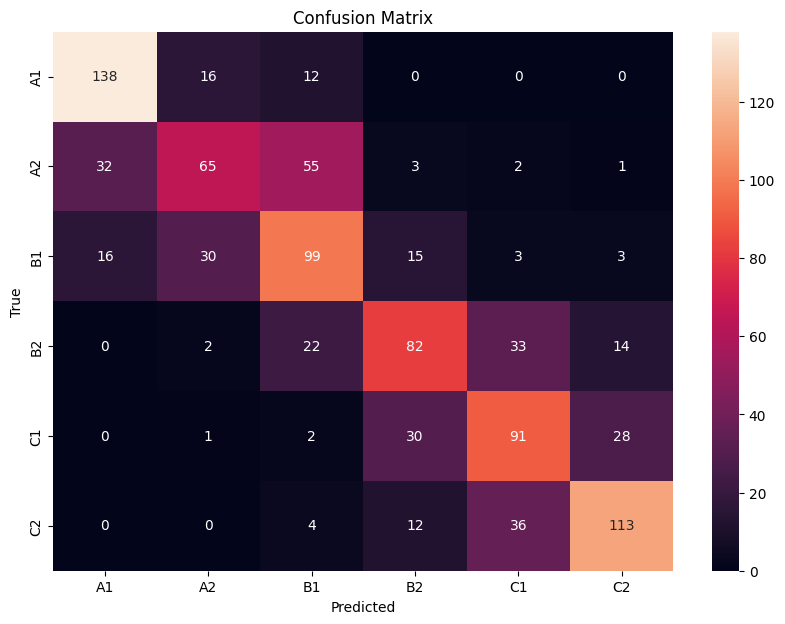

Classification Report:
              precision    recall  f1-score   support

          A1       0.74      0.83      0.78       166
          A2       0.57      0.41      0.48       158
          B1       0.51      0.60      0.55       166
          B2       0.58      0.54      0.56       153
          C1       0.55      0.60      0.57       152
          C2       0.71      0.68      0.70       165

    accuracy                           0.61       960
   macro avg       0.61      0.61      0.61       960
weighted avg       0.61      0.61      0.61       960



In [ ]:
def plot_confusion_matrix(true_labels, predictions):
    labels = ["A1", "A2", "B1", "B2", "C1", "C2"]  # Adjust labels if different
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have a function 'evaluate' that returns the needed metrics and predictions
train_batch_size = 32
val_accuracy, val_precision, val_recall, val_f1, val_loss, predictions, true_labels = evaluate(model, val_dataset, train_batch_size)

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predictions)

# Generate and print the classification report
report = classification_report(true_labels, predictions, target_names=["A1", "A2", "B1", "B2", "C1", "C2"])
print("Classification Report:")
print(report)

**Results for 8 epochs with the adjusted learning rate**

| Epoch | Current LR  | Training Loss | Validation Loss | Accuracy    | Precision   | Recall     | F1 Score   |
|-------|-------------|---------------|-----------------|-------------|-------------|------------|------------|
| 1/8   | 0.00009722  | 0.0629        | 0.0623          | 0.267708333 | 0.397342995 | 0.267708333| 0.221578047|
| 2/8   | 0.00008333  | 0.0508        | 0.2714          | 0.378125    | 0.476473793 | 0.378125   | 0.346038228|
| 3/8   | 0.00006944  | 0.0459        | 0.0451          | 0.45        | 0.553757879 | 0.45       | 0.425472568|
| 4/8   | 0.00005556  | 0.0348        | 0.0395          | 0.530208333 | 0.568265338 | 0.530208333| 0.522485341|
| 5/8   | 0.00004167  | 0.0249        | 0.0376          | 0.58125     | 0.594250948 | 0.58125    | 0.579418981|
| 6/8   | 0.00002778  | 0.0167        | 0.0433          | 0.6125      | 0.611882205 | 0.6125     | 0.608741828|
| 7/8   | 0.00001389  | 0.0107        | 0.0509          | 0.589583333 | 0.595456059 | 0.589583333| 0.591445696|
| 8/8   | 0.00000000  | 0.0058        | 0.0587          | 0.5875      | 0.595540066 | 0.5875     | 0.589796859|


In [ ]:
import plotly.graph_objects as go


data = {
    'Epoch': [f"{i+1}/8" for i in range(8)],
    'Current LR': [0.00009722, 0.00008333, 0.00006944, 0.00005556, 0.00004167, 0.00002778, 0.00001389, 0.00000000],
    'Training Loss': [0.0629, 0.0508, 0.0459, 0.0348, 0.0249, 0.0167, 0.0107, 0.0058],
    'Validation Loss': [0.0623, 0.2714, 0.0451, 0.0395, 0.0376, 0.0433, 0.0509, 0.0587],
    'Accuracy': [0.2677, 0.3781, 0.4500, 0.5302, 0.5813, 0.6125, 0.5896, 0.5875],
    'F1 Score': [0.2216, 0.3460, 0.4255, 0.5225, 0.5794, 0.6087, 0.5914, 0.5898]
}

# Create traces
trace1 = go.Scatter(x=data['Epoch'], y=data['Training Loss'], mode='lines+markers', name='Training Loss')
trace2 = go.Scatter(x=data['Epoch'], y=data['Validation Loss'], mode='lines+markers', name='Validation Loss')
trace3 = go.Scatter(x=data['Epoch'], y=data['Accuracy'], mode='lines+markers', name='Accuracy')
trace4 = go.Scatter(x=data['Epoch'], y=data['F1 Score'], mode='lines+markers', name='F1 Score')

# Create the plot for Loss
fig1 = go.Figure(data=[trace1, trace2])
fig1.update_layout(title='Training vs Validation Loss', xaxis_title='Epoch', yaxis_title='Loss', template='plotly_white')
fig1.show()

# Create the plot for Accuracy and F1 Score
fig2 = go.Figure(data=[trace3, trace4])
fig2.update_layout(title='Accuracy and F1 Score Over Epochs', xaxis_title='Epoch', yaxis_title='Metric Value', template='plotly_white')
fig2.show()


Including L1 regularisation into the training

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Load tokenizer
model_french = 'flaubert/flaubert_large_cased'
tokenizer = FlaubertTokenizer.from_pretrained(model_french, do_lowercase=False)

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            loss = outputs.loss.item()
            total_loss += loss
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
    average_loss = total_loss / len(dataset)
    return accuracy, precision, recall, f1, average_loss, predictions, true_labels


def train_and_evaluate(model, train_dataset, val_dataset, num_epochs, train_batch_size=32, l1_lambda=0.001):
    set_seed(42)
    # Calculate total training steps and warm-up steps
    total_steps = (len(train_dataset) // train_batch_size) * num_epochs
    warmup_steps = total_steps // 10  # 10% of total steps as warm-up

    # Initialize the optimizer with a higher initial learning rate
    optimizer = AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08)

    # Scheduler with warm-up phase
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    best_f1 = 0
    # Tracking lists for plotting or checking training progress
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            # Calculate L1 loss on all parameters
            l1_loss = sum(p.abs().sum() for p in model.parameters())
            total_loss = loss + l1_lambda * l1_loss  # Combine the usual loss with L1 loss

            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()  # Update the learning rate
            optimizer.zero_grad()
            total_loss += total_loss.item()
        train_loss = total_loss / len(train_dataset)
        train_losses.append(train_loss)

        # Evaluation on the validation set
        val_accuracy, val_precision, val_recall, val_f1, val_loss, _, _ = evaluate(model, val_dataset, train_batch_size)  # Update unpacking here
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Retrieve current learning rate from scheduler
        current_lr = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch+1}/{num_epochs}, Current LR: {current_lr:.8f}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Validation Metrics - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            model_filename = f'best_model_f1{best_f1:.2f}_epoch{epoch+1}.pt'
            torch.save(model.state_dict(), model_filename)
            print(f"Saved improved model as {model_filename} with F1 Score: {best_f1:.2f}")

    return train_losses, val_losses, val_accuracies, best_f1

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.56M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/896k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

In [ ]:
# Data preparation
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)

# Tokenizing the split data
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())

# Creating datasets for training and validation
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Load and prepare the model
model = FlaubertForSequenceClassification.from_pretrained(model_french, num_labels=len(label_encoder.classes_)).to(device)

# Train and evaluate the model
train_and_evaluate(model, train_dataset, val_dataset, num_epochs=8, train_batch_size=32, l1_lambda=0.001)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/1.49G [00:00<?, ?B/s]

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_large_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def plot_confusion_matrix(true_labels, predictions):
    labels = ["A1", "A2", "B1", "B2", "C1", "C2"]  # Adjust labels if different
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have a function 'evaluate' that returns the needed metrics and predictions
train_batch_size = 32
val_accuracy, val_precision, val_recall, val_f1, val_loss, predictions, true_labels = evaluate(model, val_dataset, train_batch_size)

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predictions)

# Generate and print the classification report
report = classification_report(true_labels, predictions, target_names=["A1", "A2", "B1", "B2", "C1", "C2"])
print("Classification Report:")
print(report)

### CamemBERT

#### With adjusted learning rate

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Load tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            loss = outputs.loss.item()
            total_loss += loss
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
    average_loss = total_loss / len(dataset)
    return accuracy, precision, recall, f1, average_loss, predictions, true_labels

def train_and_evaluate(model, train_dataset, val_dataset, num_epochs, train_batch_size=32):
    set_seed(42)
    # Calculate total training steps and warm-up steps
    total_steps = (len(train_dataset) // train_batch_size) * num_epochs
    warmup_steps = total_steps // 10  # 10% of total steps as warm-up

    # Initialize the optimizer with a higher initial learning rate
    optimizer = AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08)

    # Scheduler with warm-up phase
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    best_f1 = 0
    # Tracking lists for plotting or checking training progress
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()  # Update the learning rate
            optimizer.zero_grad()
            total_loss += loss.item()
        train_loss = total_loss / len(train_dataset)
        train_losses.append(train_loss)

        # Evaluation on the validation set
        val_accuracy, val_precision, val_recall, val_f1, val_loss, _, _ = evaluate(model, val_dataset, train_batch_size)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Retrieve current learning rate from scheduler
        current_lr = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch+1}/{num_epochs}, Current LR: {current_lr:.8f}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Validation Metrics - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            model_filename = f'best_model_f1{best_f1:.2f}_epoch{epoch+1}.pt'
            torch.save(model.state_dict(), model_filename)
            print(f"Saved improved model as {model_filename} with F1 Score: {best_f1:.2f}")

    return train_losses, val_losses, val_accuracies, best_f1

# Data preparation
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Training model
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(label_encoder.classes_)).to(device)
train_and_evaluate(model, train_dataset, val_dataset, num_epochs=8, train_batch_size=32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, predictions):
    labels = ["A1", "A2", "B1", "B2", "C1", "C2"]  # Adjust labels if different
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have a function 'evaluate' that returns the needed metrics and predictions
train_batch_size = 32
val_accuracy, val_precision, val_recall, val_f1, val_loss, predictions, true_labels = evaluate(model, val_dataset, train_batch_size)

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predictions)

# Generate and print the classification report
report = classification_report(true_labels, predictions, target_names=["A1", "A2", "B1", "B2", "C1", "C2"])
print("Classification Report:")
print(report)

Introducing L1 penalty

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)  # Setting the seed

# Load tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            loss = outputs.loss.item()
            total_loss += loss
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
    average_loss = total_loss / len(dataset)
    return accuracy, precision, recall, f1, average_loss, predictions, true_labels

def train_and_evaluate(model, train_dataset, val_dataset, num_epochs, train_batch_size=32, l1_lambda=1e-5):
    set_seed(42)
    # Calculate total training steps and warm-up steps
    total_steps = (len(train_dataset) // train_batch_size) * num_epochs
    warmup_steps = total_steps // 10  # 10% of total steps as warm-up

    # Initialize the optimizer with a higher initial learning rate
    optimizer = AdamW(model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08)

    # Scheduler with warm-up phase
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    best_f1 = 0
    # Tracking lists for plotting or checking training progress
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            # Add L1 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()  # Update the learning rate
            optimizer.zero_grad()
            total_loss += loss.item()

            # Empty cache to manage memory
            torch.cuda.empty_cache()

        train_loss = total_loss / len(train_dataset)
        train_losses.append(train_loss)

        # Evaluation on the validation set
        val_accuracy, val_precision, val_recall, val_f1, val_loss, _, _ = evaluate(model, val_dataset, train_batch_size)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Retrieve current learning rate from scheduler
        current_lr = scheduler.get_last_lr()[0]

        print(f"Epoch {epoch+1}/{num_epochs}, Current LR: {current_lr:.8f}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Validation Metrics - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            model_filename = f'best_model_f1{best_f1:.2f}_epoch{epoch+1}.pt'
            torch.save(model.state_dict(), model_filename)
            print(f"Saved improved model as {model_filename} with F1 Score: {best_f1:.2f}")

    return train_losses, val_losses, val_accuracies, best_f1

# Data preparation
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Training model
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(label_encoder.classes_)).to(device)
train_and_evaluate(model, train_dataset, val_dataset, num_epochs=8, train_batch_size=32)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/8, Current LR: 0.00009722, Training Loss: 2.1948, Validation Loss: 0.0352
Validation Metrics - Accuracy: 0.5135416666666667, Precision: 0.5300238772900391, Recall: 0.5135416666666667, F1 Score: 0.4933116401856762
Saved improved model as best_model_f10.49_epoch1.pt with F1 Score: 0.49
Epoch 2/8, Current LR: 0.00008333, Training Loss: 2.0949, Validation Loss: 0.0336
Validation Metrics - Accuracy: 0.5260416666666666, Precision: 0.5417523221347995, Recall: 0.5260416666666666, F1 Score: 0.5253399376628214
Saved improved model as best_model_f10.53_epoch2.pt with F1 Score: 0.53
Epoch 3/8, Current LR: 0.00006944, Training Loss: 2.0227, Validation Loss: 0.0338
Validation Metrics - Accuracy: 0.5572916666666666, Precision: 0.5703073451418355, Recall: 0.5572916666666666, F1 Score: 0.5575198677961095
Saved improved model as best_model_f10.56_epoch3.pt with F1 Score: 0.56
Epoch 4/8, Current LR: 0.00005556, Training Loss: 1.9692, Validation Loss: 0.0388
Validation Metrics - Accuracy: 0.560416

([2.1947605351607007,
  2.094911402463913,
  2.0226827184359233,
  1.9691785703102747,
  1.9276714414358138,
  1.8938079247872035,
  1.8649305909872056,
  1.8430064350366593],
 [0.03515396608660618,
  0.03358017305533091,
  0.03376291717092196,
  0.03882258056352536,
  0.051698768883943556,
  0.04858540433148543,
  0.057158896078666054,
  0.05722370085616906],
 [0.5135416666666667,
  0.5260416666666666,
  0.5572916666666666,
  0.5604166666666667,
  0.4895833333333333,
  0.56875,
  0.55,
  0.5572916666666666],
 0.5682714212577984)

| Epoch | Current LR   | Training Loss | Validation Loss | Accuracy | Precision | Recall  | F1 Score | Notes                                |
|-------|--------------|---------------|-----------------|----------|-----------|---------|----------|--------------------------------------|
| 1/8   | 0.00009722   | 2.1948        | 0.0352          | 51.35%   | 53.00%    | 51.35%  | 49.33%   | Best model saved as epoch1 with F1 0.49 |
| 2/8   | 0.00008333   | 2.0949        | 0.0336          | 52.60%   | 54.18%    | 52.60%  | 52.53%   | Best model saved as epoch2 with F1 0.53 |
| 3/8   | 0.00006944   | 2.0227        | 0.0338          | 55.73%   | 57.03%    | 55.73%  | 55.75%   | Best model saved as epoch3 with F1 0.56 |
| 4/8   | 0.00005556   | 1.9692        | 0.0388          | 56.04%   | 56.60%    | 56.04%  | 55.72%   |                                      |
| 5/8   | 0.00004167   | 1.9277        | 0.0517          | 48.96%   | 53.91%    | 48.96%  | 47.61%   |                                      |
| 6/8   | 0.00002778   | 1.8938        | 0.0486          | 56.88%   | 58.83%    | 56.88%  | 56.83%   | Best model saved as epoch6 with F1 0.57 |
| 7/8   | 0.00001389   | 1.8649        | 0.0572          | 55.00%   | 57.82%    | 55.00%  | 54.98%   |                                      |
| 8/8   | 0.00000000   | 1.8430        | 0.0572          | 55.73%   | 58.16%    | 55.73%  | 55.70%   |                                      |


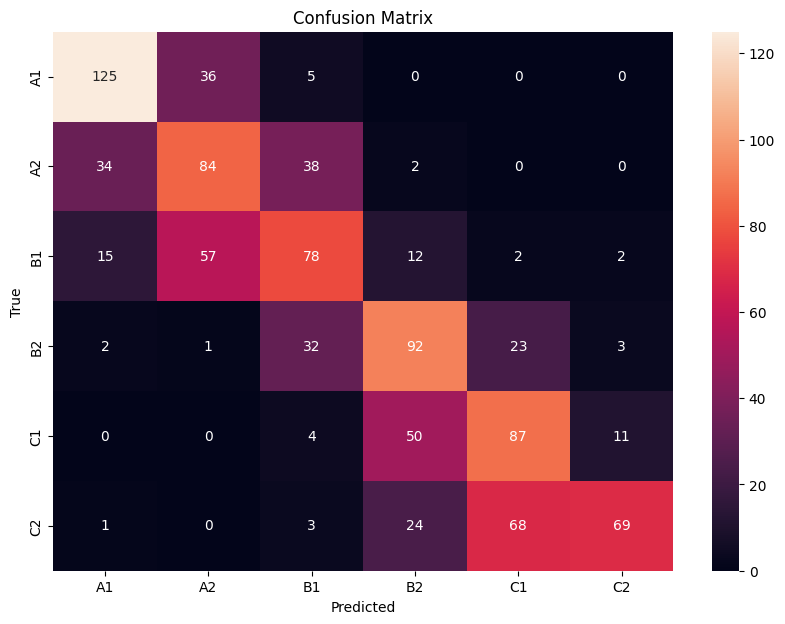

Classification Report:
              precision    recall  f1-score   support

          A1       0.71      0.75      0.73       166
          A2       0.47      0.53      0.50       158
          B1       0.49      0.47      0.48       166
          B2       0.51      0.60      0.55       153
          C1       0.48      0.57      0.52       152
          C2       0.81      0.42      0.55       165

    accuracy                           0.56       960
   macro avg       0.58      0.56      0.56       960
weighted avg       0.58      0.56      0.56       960



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(true_labels, predictions):
    labels = ["A1", "A2", "B1", "B2", "C1", "C2"]  # Adjust labels if different
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have a function 'evaluate' that returns the needed metrics and predictions
train_batch_size = 32
val_accuracy, val_precision, val_recall, val_f1, val_loss, predictions, true_labels = evaluate(model, val_dataset, train_batch_size)

# Plot the confusion matrix
plot_confusion_matrix(true_labels, predictions)

# Generate and print the classification report
report = classification_report(true_labels, predictions, target_names=["A1", "A2", "B1", "B2", "C1", "C2"])
print("Classification Report:")
print(report)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model_path = '/content/best_model_f10.57_epoch6.pt'
model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(label_encoder.classes_))
model.load_state_dict(torch.load(model_path))
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


CamembertForSequenceClassification(
  (roberta): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=Tru

In [ ]:
# Initialize the optimizer with a new learning rate
optimizer = AdamW(model.parameters(), lr=3e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate(model, dataset, batch_size):
    model.eval()
    val_loader = DataLoader(dataset, batch_size=batch_size)
    true_labels, predictions = [], []

    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)

            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
    return accuracy, precision, recall, f1

def continue_training(model, train_dataset, val_dataset, optimizer, num_epochs, train_batch_size=32):
    best_accuracy = 0  # Initialize the best accuracy
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Evaluate after each epoch
        accuracy, precision, recall, f1 = evaluate(model, val_dataset, train_batch_size)
        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {total_loss / len(train_dataset)}")
        print(f"Validation Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

        # Save the model if the current accuracy is the best
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_path = f'best_model_accuracy{best_accuracy:.4f}_epoch{epoch+1}.pt'
            torch.save(model.state_dict(), best_model_path)
            print(f"Saved improved model as {best_model_path} with Accuracy: {best_accuracy:.4f}")

# Continue training
continue_training(model, train_dataset, val_dataset, optimizer, num_epochs=3)

OutOfMemoryError: CUDA out of memory. Tried to allocate 142.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 75.06 MiB is free. Process 31221 has 14.67 GiB memory in use. Of the allocated memory 13.76 GiB is allocated by PyTorch, and 802.50 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### With the learning rate 5e-05

In [ ]:
from transformers import AutoModel, AutoTokenizer
import torch

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CamembertTokenizer, CamembertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import random
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Load tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    total_loss = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            loss = outputs.loss.item()
            total_loss += loss
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=1)
    average_loss = total_loss / len(dataset)
    return accuracy, precision, recall, f1, average_loss

def train_and_evaluate(model, train_dataset, val_dataset, num_epochs=6, train_batch_size=32):
    set_seed(42)
    # Calculate total training steps
    total_steps = (len(train_dataset) // train_batch_size) * num_epochs

    # Initialize the optimizer with the specified learning rate
    optimizer = AdamW(model.parameters(), lr=5e-05)

    # Scheduler with no warm-up for simplicity, since not specified differently
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Wrap model for multi-GPU training
    model = torch.nn.DataParallel(model)
    model.to(device)

    best_f1 = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()  # Update the learning rate
            optimizer.zero_grad()
            total_loss += loss.item()
        train_loss = total_loss / len(train_dataset)

        # Evaluation on the validation set
        val_accuracy, val_precision, val_recall, val_f1, val_loss = evaluate(model, val_dataset, train_batch_size)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
        print(f"Validation Metrics - Accuracy: {val_accuracy}, Precision: {val_precision}, Recall: {val_recall}, F1 Score: {val_f1}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            model_filename = f'best_model_f1{best_f1:.2f}_epoch{epoch+1}.pt'
            torch.save(model.module.state_dict(), model_filename)  # Save the underlying model parameters
            print(f"Saved improved model as {model_filename} with F1 Score: {best_f1:.2f}")

    return best_f1

# Data preparation and training
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

model = CamembertForSequenceClassification.from_pretrained('camembert-base', num_labels=len(label_encoder.classes_))
train_and_evaluate(model, train_dataset, val_dataset, num_epochs=6, train_batch_size=32)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/6, Training Loss: 0.0456, Validation Loss: 0.0374
Validation Metrics - Accuracy: 0.4864583333333333, Precision: 0.4749508551164427, Recall: 0.4864583333333333, F1 Score: 0.4546505882634181
Saved improved model as best_model_f10.45_epoch1.pt with F1 Score: 0.45
Epoch 2/6, Training Loss: 0.0343, Validation Loss: 0.0375
Validation Metrics - Accuracy: 0.475, Precision: 0.49297366458074, Recall: 0.475, F1 Score: 0.46400132108110564
Saved improved model as best_model_f10.46_epoch2.pt with F1 Score: 0.46
Epoch 3/6, Training Loss: 0.0283, Validation Loss: 0.0334
Validation Metrics - Accuracy: 0.534375, Precision: 0.5369884645356318, Recall: 0.534375, F1 Score: 0.528875257713811
Saved improved model as best_model_f10.53_epoch3.pt with F1 Score: 0.53
Epoch 4/6, Training Loss: 0.0234, Validation Loss: 0.0349
Validation Metrics - Accuracy: 0.5364583333333334, Precision: 0.5622178430113175, Recall: 0.5364583333333334, F1 Score: 0.5295547162168579
Saved improved model as best_model_f10.53_ep

0.5592712270669875

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Function to get predictions and true labels
def get_predictions_and_labels(model, dataset, batch_size):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    return predictions, true_labels

# Compute predictions and true labels using the validation dataset
predictions, true_labels = get_predictions_and_labels(model, val_dataset, batch_size=32)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Compute the classification report
class_report = classification_report(true_labels, predictions, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report)

Confusion Matrix:
[[141  20   5   0   0   0]
 [ 43  80  33   2   0   0]
 [ 20  53  84   7   0   2]
 [  1   0  55  75  18   4]
 [  0   0   7  79  54  12]
 [  0   0   5  38  52  70]]
Classification Report:
              precision    recall  f1-score   support

          A1       0.69      0.85      0.76       166
          A2       0.52      0.51      0.51       158
          B1       0.44      0.51      0.47       166
          B2       0.37      0.49      0.42       153
          C1       0.44      0.36      0.39       152
          C2       0.80      0.42      0.55       165

    accuracy                           0.53       960
   macro avg       0.54      0.52      0.52       960
weighted avg       0.55      0.53      0.52       960



### Predicting the values with the trained model

#### Prediction on the provided dataset

This section was used to make the predictions based on the trained model

In [ ]:
# Load the best model
best_model_path = "best_model_f10.61_epoch6.pt"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)

FlaubertForSequenceClassification(
  (transformer): FlaubertModel(
    (position_embeddings): Embedding(512, 1024)
    (embeddings): Embedding(68729, 1024, padding_idx=2)
    (layer_norm_emb): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    (attentions): ModuleList(
      (0-23): 24 x MultiHeadAttention(
        (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (out_lin): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (layer_norm1): ModuleList(
      (0-23): 24 x LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    )
    (ffns): ModuleList(
      (0-23): 24 x TransformerFFN(
        (lin1): Linear(in_features=1024, out_features=4096, bias=True)
        (lin2): Linear(in_features=4096, out_features=1024, bias=True)
        (act): GELUActivation()
      )
    )
    (layer_norm2): Mo

In [ ]:
new_sentences = our_predictions['sentence'].tolist()
# Tokenize the new data
new_encodings = tokenize_data(new_sentences)

In [ ]:
class PredictionDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

# Create dataset
prediction_dataset = PredictionDataset(new_encodings)

# Create DataLoader
prediction_loader = DataLoader(prediction_dataset, batch_size=16)  # You can adjust the batch size


In [ ]:
# Prediction function using the best model
def predict(model, dataset):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=16):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
    return predictions

# Predict the difficulties using the best model
predicted_labels_indices = predict(model, prediction_dataset)

In [ ]:
# Decode label indices to actual labels
predicted_difficulties = label_encoder.inverse_transform(predicted_labels_indices)

# Add predictions to dataframe
our_predictions['difficulty'] = predicted_difficulties
print(our_predictions)

        id                                           sentence difficulty
0        0  Nous dûmes nous excuser des propos que nous eû...         C2
1        1  Vous ne pouvez pas savoir le plaisir que j'ai ...         B1
2        2  Et, paradoxalement, boire froid n'est pas la b...         B1
3        3  Ce n'est pas étonnant, car c'est une saison my...         A2
4        4  Le corps de Golo lui-même, d'une essence aussi...         C2
...    ...                                                ...        ...
1195  1195  C'est un phénomène qui trouve une accélération...         B1
1196  1196  Je vais parler au serveur et voir si on peut d...         A2
1197  1197  Il n'était pas comme tant de gens qui par pare...         C2
1198  1198      Ils deviennent dangereux pour notre économie.         B2
1199  1199  Son succès a généré beaucoup de réactions néga...         B2

[1200 rows x 3 columns]


In [ ]:
df_submission_flaubert = our_predictions[['id', 'difficulty']]

df_submission_flaubert.head()

,id,difficulty
0,0,C2
1,1,B1
2,2,B1
3,3,A2
4,4,C2


In [ ]:
df_submission_flaubert.to_csv('submission_flaubert.csv', index=False)


In [ ]:
fig = px.histogram(df_submission_flaubert, x='difficulty', color='difficulty',
                   title='Distribution of Predicted Sentence Difficulties',
                   labels={'difficulty': 'Difficulty Level'},
                   template='plotly_white',
                   opacity=0.8)

fig.update_layout(
    xaxis_title='Difficulty Level',
    yaxis_title='Frequency',
    bargap=0.2,
)

# Show interactive plot
fig.show()

#### Prediction for the video on  YouTube

![YouTube Video](https://drive.google.com/uc?export=view&id=1A-QgMNBh1DNDSIQlxJ9FR4CNVqZlyAc1 "Image Title")


We wanted to use our model to make the predictions on the videos targeted to the beginner French learners. We choose the video on YouTube and created the df with the sentences from the video.

The video selected to make predicitons is: [What Do French People Actually Eat? | Easy French 189](https://www.youtube.com/watch?v=p65EBC9lW9k&list=PLnazreCxpqRmpb4lGvzvCGXIXZkL3Nc27&index=4)

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed=42):
    """Set seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    random.seed(worker_seed)
    np.random.seed(worker_seed)

# Set seed early in the script
set_seed(42)


# Load tokenizer
model_french = 'flaubert/flaubert_large_cased'
tokenizer = FlaubertTokenizer.from_pretrained(model_french, do_lowercase=False)

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    return accuracy, precision, recall, f1

# Training and evaluation function
def train_and_evaluate(model, train_dataset, val_dataset, num_epochs, train_batch_size):
    set_seed(42)
    optimizer = AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.999), eps=1e-08)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=(len(train_dataset) // train_batch_size) * num_epochs)

    best_f1 = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        average_loss = total_loss / len(train_dataset)
        accuracy, precision, recall, f1 = evaluate(model, val_dataset, train_batch_size)
        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate 5e-5, Average Loss: {average_loss}")
        print(f"Validation Metrics - Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")

        if f1 > best_f1:  # Considering F1 score for model saving
            best_f1 = f1
            model_filename = f'best_model_f1{best_f1:.2f}_epoch{epoch+1}.pt'
            torch.save(model.state_dict(), model_filename)
            print(f"Saved improved model as {model_filename} with F1 Score: {best_f1:.2f}")

    return average_loss, best_f1

# Data preparation
tokenized_data = tokenize_data(df['sentence'].tolist())
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Training model
model = FlaubertForSequenceClassification.from_pretrained(model_french, num_labels=len(label_encoder.classes_)).to(device)
train_and_evaluate(model, train_dataset, val_dataset, num_epochs=6, train_batch_size=32)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_large_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This i

Epoch 1/6, Learning Rate 5e-5, Average Loss: 0.060415726232652865
Validation Metrics - Accuracy: 0.39375, Precision: 0.5144486118456114, Recall: 0.39375, F1 Score: 0.37010242960842604
Saved improved model as best_model_f10.37_epoch1.pt with F1 Score: 0.37
Epoch 2/6, Learning Rate 5e-5, Average Loss: 0.042251459788531065
Validation Metrics - Accuracy: 0.49895833333333334, Precision: 0.5244477174856967, Recall: 0.49895833333333334, F1 Score: 0.4860279594126909
Saved improved model as best_model_f10.49_epoch2.pt with F1 Score: 0.49
Epoch 3/6, Learning Rate 5e-5, Average Loss: 0.03400669548039635
Validation Metrics - Accuracy: 0.5427083333333333, Precision: 0.5798898318839179, Recall: 0.5427083333333333, F1 Score: 0.5209575383895645
Saved improved model as best_model_f10.52_epoch3.pt with F1 Score: 0.52
Epoch 4/6, Learning Rate 5e-5, Average Loss: 0.027572925784625113
Validation Metrics - Accuracy: 0.5583333333333333, Precision: 0.5704371203940142, Recall: 0.5583333333333333, F1 Score: 0.5

(0.017435335953875135, 0.5825951650289466)

In [ ]:
sentences = [
    "Salut les amis, bienvenue dans ce nouvel épisode.",
    "Aujourd'hui je suis dans le 11e arrondissement et je vais demander aux gens de parler de leurs habitudes alimentaires.",
    "Alors c'est parti, qu'est-ce que vous avez mangé depuis ce matin?",
    "Rien du tout parce que j'organise des cours de yoga et des expériences de transe consciente, donc je n'ai pas mangé avant mais je mangerai après.",
    "Un smoothie ce matin et ce midi une salade de lentille avec des œufs pochés.",
    "Alors une petite tartine de Nutella avec un bon café et puis ce midi j'ai mangé des brocolis avec une salade verte assaisonnée avec de l'huile d'olive donc très light.",
    "Qu'est-ce que vous avez mangé dans la journée depuis que vous vous êtes réveillé?",
    "Ce matin, j'ai mangé du pain avec du beurre et du fromage et un café au lait et ce midi, j'ai mangé dans un restaurant grec, c'était une sorte de pita avec du taboulé, de la tapenade et du tzatziki.",
    "Voilà, qu'est-ce que vous avez mangé aujourd'hui depuis que vous êtes debout?",
    "On sort tout juste du restaurant Le PNY donc on a mangé de gros hamburgers, la très bonne viande, et ce matin pour le petit-déjeuner pas vraiment petit-déjeuner on sort de soirée donc on est rentré relativement tard et on a pas beaucoup mangé le matin, si si il y avait le café quand même.",
    "Alors du coup ce matin je n'ai pas mangé de petit déjeuner mais on est allé au marché à Véronais à Berc à Cour Saint-Émilion et donc on a mangé des petits plats typiques de là-bas, Aligo saucisses tout ça très sympa, je conseille.",
    "Super, vous avez dit que c'était où à Cour Saint-Émilion dans le 12e, ok très bien.",
    "Alors vous, vous avez mangé la même chose aussi?",
    "Des plats avéronnais, que de la LIGO, je n'ai rien mangé d'autre que de la LIGO de toute la journée.",
    "Dès mon réveil, et alors comme c'est pour les étrangers cette vidéo, peut-être les gens ne savent pas ce que c'est, vous pouvez expliquer ce que c'est la LIGO, quels sont les ingrédients de base?",
    "Ok donc moi c'est la première fois que j'en mangeais aujourd'hui donc je sais, c'est de la pomme de terre, du lait, de la crème et du fromage, beaucoup de fromage, que du fromage et c'est sous quelle forme?",
    "C'est plutôt liquide, c'est comme de la purée quoi avec des grumeaux.",
    "Qu'est-ce que vous avez mangé aujourd'hui depuis ce matin?",
    "Alors j'ai pris un bol de museli avec du lait d'avoine et une banane et un curry d'aubergine avec un banana bread.",
    "Alors j'ai mangé du taboulé libanais et du poulet rôti et du pain grillé, donc au petit-déjeuner du pain grillé, exactement.",
    "Et alors le taboulé et le poulet rôti c'était fait maison?",
    "Non, c'était pas fait maison, j'avais pas le temps, vous l'avez mangé où?",
    "Ah je l'ai mangé à la maison mais c'était pas fait maison, c'était acheté à la boucherie traiteur.",
    "Est-ce que c'est le genre de chose que vous mangez habituellement ou c'est exceptionnel?",
    "Euh non, c'est plutôt exceptionnel, d'habitude je mange plus des trucs là, genre des pâtes, des trucs comme ça.",
    "Est-ce que vous avez mangé aujourd'hui est-ce que c'est dans vos habitudes ou c'est juste le dimanche ou juste le weekend?",
    "Plutôt dans mes habitudes, vous mangez tous les jours des smoothies le matin?",
    "Ouais, ok, et est-ce qu'il y a des choses que vous mangez tous les jours à part les smoothies, un aliment par exemple du pain ou un légume ou un fruit?",
    "Non, je pense pas, bah comme fruits si des bananes je vous dirais du coup mais sinon non, je pense pas, je sais pas trop, vous mangez tous les jours des bananes?",
    "Ouais, plusieurs bananes dans la journée?",
    "Non, une seule."
]

df_sentences = pd.DataFrame({
    "ID": range(1, len(sentences) + 1),
    "Sentence": sentences
})

df_sentences


,ID,Sentence
0,1,"Salut les amis, bienvenue dans ce nouvel épisode."
1,2,Aujourd'hui je suis dans le 11e arrondissement...
2,3,"Alors c'est parti, qu'est-ce que vous avez man..."
3,4,Rien du tout parce que j'organise des cours de...
4,5,Un smoothie ce matin et ce midi une salade de ...
5,6,Alors une petite tartine de Nutella avec un bo...
6,7,Qu'est-ce que vous avez mangé dans la journée ...
7,8,"Ce matin, j'ai mangé du pain avec du beurre et..."
8,9,"Voilà, qu'est-ce que vous avez mangé aujourd'h..."
9,10,On sort tout juste du restaurant Le PNY donc o...


In [ ]:
best_model_path = "best_model_f10.58_epoch6.pt"
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)

FlaubertForSequenceClassification(
  (transformer): FlaubertModel(
    (position_embeddings): Embedding(512, 1024)
    (embeddings): Embedding(68729, 1024, padding_idx=2)
    (layer_norm_emb): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    (attentions): ModuleList(
      (0-23): 24 x MultiHeadAttention(
        (q_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (k_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (v_lin): Linear(in_features=1024, out_features=1024, bias=True)
        (out_lin): Linear(in_features=1024, out_features=1024, bias=True)
      )
    )
    (layer_norm1): ModuleList(
      (0-23): 24 x LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
    )
    (ffns): ModuleList(
      (0-23): 24 x TransformerFFN(
        (lin1): Linear(in_features=1024, out_features=4096, bias=True)
        (lin2): Linear(in_features=4096, out_features=1024, bias=True)
        (act): GELUActivation()
      )
    )
    (layer_norm2): Mo

In [ ]:
youtube_sentences = df_sentences['Sentence'].tolist()
# Tokenize the new data
new_encodings_youtube = tokenize_data(youtube_sentences)

In [ ]:
class PredictionDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

# Create dataset
prediction_dataset_youtube = PredictionDataset(new_encodings_youtube)

# Create DataLoader
prediction_loader_youtube = DataLoader(prediction_dataset_youtube, batch_size=16)

In [ ]:
# Prediction function using the best model
def predict(model, dataset):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=16):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
    return predictions

# Predict the difficulties using the best model
predicted_labels_indices_youtube = predict(model, prediction_dataset_youtube)

In [ ]:
# Decode label indices to actual labels
predicted_difficulties_youtube = label_encoder.inverse_transform(predicted_labels_indices_youtube)

# Add predictions to dataframe
df_sentences['difficulty'] = predicted_difficulties_youtube
print(df_sentences)

    ID                                           Sentence difficulty
0    1  Salut les amis, bienvenue dans ce nouvel épisode.         A1
1    2  Aujourd'hui je suis dans le 11e arrondissement...         A2
2    3  Alors c'est parti, qu'est-ce que vous avez man...         A2
3    4  Rien du tout parce que j'organise des cours de...         B1
4    5  Un smoothie ce matin et ce midi une salade de ...         A1
5    6  Alors une petite tartine de Nutella avec un bo...         B1
6    7  Qu'est-ce que vous avez mangé dans la journée ...         A2
7    8  Ce matin, j'ai mangé du pain avec du beurre et...         B1
8    9  Voilà, qu'est-ce que vous avez mangé aujourd'h...         A2
9   10  On sort tout juste du restaurant Le PNY donc o...         A2
10  11  Alors du coup ce matin je n'ai pas mangé de pe...         B1
11  12  Super, vous avez dit que c'était où à Cour Sai...         A2
12  13   Alors vous, vous avez mangé la même chose aussi?         A2
13  14  Des plats avéronnais, que 

In [ ]:
df_sentences.to_csv('df_sentences_youtube.csv', index=False)

In [ ]:
fig = px.histogram(df_sentences, x='difficulty', color='difficulty',
                   title='Distribution of Predicted Sentence Difficulties',
                   labels={'difficulty': 'Difficulty Level'},
                   template='plotly_white',
                   opacity=0.8)

fig.update_layout(
    xaxis_title='Difficulty Level',
    yaxis_title='Frequency',
    bargap=0.2,
)

# Show interactive plot
fig.show()

The video was produced for beginner French learners. From the plot, we can see that 16 sentences fall into the A2 category and 4 into A1. Additionally, some sentences are classified as more difficult, at the B1 level by the model. This could pose challenges for learners but also encourage them to acquire new vocabulary and further develop their skills.

### Best training FlauBERT

In this section we describe the process which led us to the model on Kaggle of 0.610. This process was not that well documented as the steps above.

##### Evaluating the model using various hyperparameters

Each training session was conducted with a distinct learning rate, ranging from 1e-06 to 2e-05. The goal was to find an optimal rate that balances fast learning without overshooting the minimum of the loss function

For each learning rate, the model was trained over two epochs. This limited exposure was designed to quickly assess the impact of each learning rate without extensive computational cost.


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Load tokenizer
model_french = 'flaubert/flaubert_large_cased'
tokenizer = FlaubertTokenizer.from_pretrained(model_french, do_lowercase=False)

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    return accuracy_score(true_labels, predictions)

# Training and evaluation function
def train_and_evaluate(model, train_dataset, val_dataset, learning_rate, num_epochs, train_batch_size, eval_batch_size):
    set_seed(42)  # Setting the seed
    optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=(len(train_dataset) // train_batch_size) * num_epochs)

    best_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        average_loss = total_loss / len(DataLoader(train_dataset, batch_size=train_batch_size))
        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate {learning_rate}, Average Loss: {average_loss}")

        validation_accuracy = evaluate(model, val_dataset, eval_batch_size)
        print(f"Validation Accuracy: {validation_accuracy}")

        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            model_filename = f'best_model_lr{learning_rate}_ep{num_epochs}_acc{best_accuracy:.2f}.pt'
            model_save_path = os.path.join(drive_path, model_filename)
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved improved model as {model_filename} with accuracy: {best_accuracy}")

        #if validation_accuracy > best_accuracy:
         #   best_accuracy = validation_accuracy
         #   torch.save(model.state_dict(), f'best_model_{learning_rate}_{num_epochs}.pt')
         #   print("Saved improved model with accuracy: {best_accuracy}")

    return average_loss, best_accuracy

# Prepare data
tokenized_data = tokenize_data(df['sentence'].tolist())
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))

# Splitting the dataset into training and testing sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)

# Tokenize train and validation texts
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())

# Creating datasets for train and validation
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Parameters
learning_rates = [1e-5, 2e-05, 5e-6, 1e-06]
num_epochs = 2
train_batch_size = 16
eval_batch_size = 16

# Hyperparameter tuning
results = []
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = FlaubertForSequenceClassification.from_pretrained(model_french, num_labels=len(label_encoder.classes_)).to(device)
    loss, accuracy = train_and_evaluate(model, train_dataset, val_dataset, lr, num_epochs, train_batch_size, eval_batch_size)  # Using the correct dataset split for evaluation
    results.append((lr, loss, accuracy))

# Selecting the best model based on accuracy
best_result = max(results, key=lambda x: x[2])
print(f"Best Learning Rate: {best_result[0]} with Loss: {best_result[1]} and Accuracy: {best_result[2]}")

The results that we first obtained after the training:

| Learning Rate | Epoch | Average Loss    | Validation Accuracy |
|---------------|-------|-----------------|---------------------|
| 1e-05         | 1/2   | 1.776790196200212 | 0.3614583333333333  |
| 1e-05         | 2/2   | 1.4493117819229762| 0.4354166666666667  |
| 2e-05         | 1/2   | 1.8514792347947757| 0.43020833333333336 |
| 2e-05         | 2/2   | 1.3657454945147038| 0.5104166666666666  |
| 5e-06         | 1/2   | 2.1787539795041084| 0.3072916666666667  |
| 5e-06         | 2/2   | 1.7749672616521517| 0.346875            |
| 1e-06         | 1/2   | 2.78974984139204  | 0.19375             |
| 1e-06         | 2/2   | 2.3164451534549397| 0.20208333333333334 |



We achieved an accuracy of 51% within just two epochs using a learning rate of 2e-05. Encouraged by these results, we have decided to continue refining the model with this learning rate. To explore the model's capacity further, we plan to keep the batch size to 16 and adjust the learning rate to 3e-05, while extending the training period to 15 epochs.

##### Model 3e-05 with large number of epochs and batch size 16

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Load tokenizer
model_french = 'flaubert/flaubert_large_cased'
tokenizer = FlaubertTokenizer.from_pretrained(model_french, do_lowercase=False)

# Tokenization function
def tokenize_data(texts, max_length=512):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")

# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Evaluation function
def evaluate(model, dataset, batch_size):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in DataLoader(dataset, batch_size=batch_size):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            pred_labels = torch.argmax(logits, dim=-1)
            predictions.extend(pred_labels.cpu().numpy())
            true_labels.extend(batch['labels'].cpu().numpy())
    return accuracy_score(true_labels, predictions)

# Training and evaluation function
from google.colab import files

def train_and_evaluate(model, train_dataset, val_dataset, learning_rate, num_epochs, train_batch_size, eval_batch_size):
    set_seed(42)  # Setting the seed
    optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=(len(train_dataset) // train_batch_size) * num_epochs)

    best_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch in DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        average_loss = total_loss / len(DataLoader(train_dataset, batch_size=train_batch_size))
        validation_accuracy = evaluate(model, val_dataset, eval_batch_size)
        print(f"Epoch {epoch+1}/{num_epochs}, Learning Rate {learning_rate}, Average Loss: {average_loss}")
        print(f"Validation Accuracy: {validation_accuracy}")

        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            model_filename = f'best_model_lr{learning_rate}_ep{epoch+1}_acc{best_accuracy:.2f}.pt'
            torch.save(model.state_dict(), model_filename)
            print(f"Saved improved model as {model_filename} with accuracy: {best_accuracy:.2f}")
            files.download(model_filename)  # Trigger download

    return average_loss, best_accuracy

# Prepare data
tokenized_data = tokenize_data(df['sentence'].tolist())
label_encoder = LabelEncoder()
labels = torch.tensor(label_encoder.fit_transform(df['difficulty']))

# Splitting the dataset into training and testing sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['sentence'], labels, test_size=0.2, random_state=42)

# Tokenize train and validation texts
train_encodings = tokenize_data(train_texts.tolist())
val_encodings = tokenize_data(val_texts.tolist())

# Creating datasets for train and validation
train_dataset = TextDataset(train_encodings, train_labels)
val_dataset = TextDataset(val_encodings, val_labels)

# Parameters
chosen_learning_rate = 3e-05
num_epochs = 15
train_batch_size = 16
eval_batch_size = 16

# No longer using a loop for hyperparameter tuning
print(f"Training with learning rate: {chosen_learning_rate}")
model = FlaubertForSequenceClassification.from_pretrained(model_french, num_labels=len(label_encoder.classes_)).to(device)
loss, accuracy = train_and_evaluate(model, train_dataset, val_dataset, chosen_learning_rate, num_epochs, train_batch_size, eval_batch_size)

print(f"Training complete. Final Loss: {loss}, Final Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Training with learning rate: 3e-05


Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_large_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/15, Learning Rate 3e-05, Average Loss: 1.6861949928104878
Validation Accuracy: 0.459375
Saved improved model as best_model_lr3e-05_ep1_acc0.46.pt with accuracy: 0.46


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 2/15, Learning Rate 3e-05, Average Loss: 1.293043205142021
Validation Accuracy: 0.5104166666666666
Saved improved model as best_model_lr3e-05_ep2_acc0.51.pt with accuracy: 0.51


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 3/15, Learning Rate 3e-05, Average Loss: 1.1450499561925729
Validation Accuracy: 0.5020833333333333
Epoch 4/15, Learning Rate 3e-05, Average Loss: 0.9551384929567576
Validation Accuracy: 0.5479166666666667
Saved improved model as best_model_lr3e-05_ep4_acc0.55.pt with accuracy: 0.55


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 5/15, Learning Rate 3e-05, Average Loss: 0.8847448159009218
Validation Accuracy: 0.5552083333333333
Saved improved model as best_model_lr3e-05_ep5_acc0.56.pt with accuracy: 0.56


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 6/15, Learning Rate 3e-05, Average Loss: 0.6622620061660807
Validation Accuracy: 0.5541666666666667
Epoch 7/15, Learning Rate 3e-05, Average Loss: 0.5362344713571171
Validation Accuracy: 0.5625
Saved improved model as best_model_lr3e-05_ep7_acc0.56.pt with accuracy: 0.56


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 8/15, Learning Rate 3e-05, Average Loss: 0.4089817595978578
Validation Accuracy: 0.5875
Saved improved model as best_model_lr3e-05_ep8_acc0.59.pt with accuracy: 0.59


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 9/15, Learning Rate 3e-05, Average Loss: 0.33824505883579453
Validation Accuracy: 0.5885416666666666
Saved improved model as best_model_lr3e-05_ep9_acc0.59.pt with accuracy: 0.59


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 10/15, Learning Rate 3e-05, Average Loss: 0.267180602105024
Validation Accuracy: 0.5770833333333333
Epoch 11/15, Learning Rate 3e-05, Average Loss: 0.20691650847826773
Validation Accuracy: 0.590625
Saved improved model as best_model_lr3e-05_ep11_acc0.59.pt with accuracy: 0.59


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 12/15, Learning Rate 3e-05, Average Loss: 0.18459767014331493
Validation Accuracy: 0.5927083333333333
Saved improved model as best_model_lr3e-05_ep12_acc0.59.pt with accuracy: 0.59


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 13/15, Learning Rate 3e-05, Average Loss: 0.1560351345979143
Validation Accuracy: 0.5958333333333333
Saved improved model as best_model_lr3e-05_ep13_acc0.60.pt with accuracy: 0.60


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 14/15, Learning Rate 3e-05, Average Loss: 0.11608232750440947
Validation Accuracy: 0.584375
Epoch 15/15, Learning Rate 3e-05, Average Loss: 0.11170685825879142
Validation Accuracy: 0.5885416666666666
Training complete. Final Loss: 0.11170685825879142, Final Accuracy: 0.5958333333333333


The results of the training:

| Epoch  | Learning Rate | Average Loss    | Validation Accuracy | Notes                                     |
|--------|---------------|-----------------|---------------------|-------------------------------------------|
| 1/15   | 3e-05         | 1.6861949928105 | 0.459375            | Saved as `best_model_lr3e-05_ep1_acc0.46.pt`  |
| 2/15   | 3e-05         | 1.2930432051420 | 0.5104167           | Saved as `best_model_lr3e-05_ep2_acc0.51.pt`  |
| 3/15   | 3e-05         | 1.1450499561926 | 0.5020833           |                                           |
| 4/15   | 3e-05         | 0.9551384929568 | 0.5479167           | Saved as `best_model_lr3e-05_ep4_acc0.55.pt`  |
| 5/15   | 3e-05         | 0.8847448159009 | 0.5552083           | Saved as `best_model_lr3e-05_ep5_acc0.56.pt`  |
| 6/15   | 3e-05         | 0.6622620061661 | 0.5541667           |                                           |
| 7/15   | 3e-05         | 0.5362344713571 | 0.5625              | Saved as `best_model_lr3e-05_ep7_acc0.56.pt`  |
| 8/15   | 3e-05         | 0.4089817595979 | 0.5875              | Saved as `best_model_lr3e-05_ep8_acc0.59.pt`  |
| 9/15   | 3e-05         | 0.3382450588358 | 0.5885417           | Saved as `best_model_lr3e-05_ep9_acc0.59.pt`  |
| 10/15  | 3e-05         | 0.2671806021050 | 0.5770833           |                                           |
| 11/15  | 3e-05         | 0.2069165084783 | 0.590625            | Saved as `best_model_lr3e-05_ep11_acc0.59.pt` |
| 12/15  | 3e-05         | 0.1845976701433 | 0.5927083           | Saved as `best_model_lr3e-05_ep12_acc0.59.pt` |
| 13/15  | 3e-05         | 0.1560351345979 | 0.5958333           | Saved as `best_model_lr3e-05_ep13_acc0.60.pt` |
| 14/15  | 3e-05         | 0.1160823275044 | 0.584375            |                                           |
| 15/15  | 3e-05         | 0.1117068582588 | 0.5885417           |                                           |


The program saved the best model at the 13th epoch i.e., and we can see that the model accuracy goes further down while the learning rate decreases.


**Best model:**

- Epoch 13/15, Learning Rate 3e-05,
- Average Loss: 0.1560351345979143
- Validation Accuracy: 0.5958333333333333

Saved improved model as best_model_lr3e-05_ep13_acc0.60.pt with accuracy: 0.60

##### Continued model training

We extended the training of our best-performing model by increasing the number of epochs and reducing the learning rate

In [ ]:
#Learning rate for fine-tuning
# Parameters for fine-tuning
fine_tuning_learning_rate = 1e-05  # Lower learning rate for fine-tuning
num_epochs_new = 3  # Reduce the number of epochs to 3 for quick fine-tuning
train_batch_size = 16  # Training batch size
eval_batch_size = 16  # Evaluation batch size

# Start fine-tuning with the updated settings
print(f"Starting fine-tuning with learning rate: {fine_tuning_learning_rate} for {num_epochs_new} epochs")
loss, accuracy = train_and_evaluate(model, train_dataset, val_dataset, fine_tuning_learning_rate, num_epochs_new, train_batch_size, eval_batch_size)
print(f"Fine-tuning complete. Final Loss: {loss}, Final Accuracy: {accuracy}")


In [ ]:
#best_model_path = 'best_model_lr1e-05_ep2_acc0.61.pt'  # Update this path as needed --> Check which moedl actually produced the highest accuracy from the previous training
#model.load_state_dict(torch.load(best_model_path, map_location=device))
#model.to(device)

We made predictions and then continued training the model again with different parameter for the learning rate

In [ ]:
#Learning rate for fine-tuning
# Parameters for fine-tuning
fine_tuning_learning_rate = 2e-05
num_epochs_new = 6  # Reduce the number of epochs to 3 for quick fine-tuning
train_batch_size = 16  # Training batch size
eval_batch_size = 16  # Evaluation batch size

# Start fine-tuning with the updated settings
print(f"Starting fine-tuning with learning rate: {fine_tuning_learning_rate} for {num_epochs_new} epochs")
loss, accuracy = train_and_evaluate(model, train_dataset, val_dataset, fine_tuning_learning_rate, num_epochs_new, train_batch_size, eval_batch_size)
print(f"Fine-tuning complete. Final Loss: {loss}, Final Accuracy: {accuracy}")


Starting fine-tuning with learning rate: 2e-05 for 6 epochs
Epoch 1/6, Learning Rate 2e-05, Average Loss: 0.06369797926811316
Validation Accuracy: 0.5697916666666667
Saved improved model as best_model_lr2e-05_ep1_acc0.57.pt with accuracy: 0.57


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 2/6, Learning Rate 2e-05, Average Loss: 0.0697462880416424
Validation Accuracy: 0.5864583333333333
Saved improved model as best_model_lr2e-05_ep2_acc0.59.pt with accuracy: 0.59


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 3/6, Learning Rate 2e-05, Average Loss: 0.08821526710380567
Validation Accuracy: 0.5697916666666667
Epoch 4/6, Learning Rate 2e-05, Average Loss: 0.03653059935331839
Validation Accuracy: 0.584375
Epoch 5/6, Learning Rate 2e-05, Average Loss: 0.03376048295150819
Validation Accuracy: 0.5864583333333333
Epoch 6/6, Learning Rate 2e-05, Average Loss: 0.02625617888628161
Validation Accuracy: 0.5916666666666667
Saved improved model as best_model_lr2e-05_ep6_acc0.59.pt with accuracy: 0.59


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fine-tuning complete. Final Loss: 0.02625617888628161, Final Accuracy: 0.5916666666666667


| Epoch | Learning Rate | Average Loss        | Validation Accuracy | Notes                                          |
|-------|---------------|---------------------|---------------------|------------------------------------------------|
| 1/6   | 2e-05         | 0.06369797926811316 | 0.5697916666666667  | Saved as `best_model_lr2e-05_ep1_acc0.57.pt`    |
| 2/6   | 2e-05         | 0.0697462880416424  | 0.5864583333333333  | Saved as `best_model_lr2e-05_ep2_acc0.59.pt`    |
| 3/6   | 2e-05         | 0.08821526710380567 | 0.5697916666666667  |                                                |
| 4/6   | 2e-05         | 0.03653059935331839 | 0.584375            |                                                |
| 5/6   | 2e-05         | 0.03376048295150819 | 0.5864583333333333  |                                                |
| 6/6   | 2e-05         | 0.02625617888628161 | 0.5916666666666667  | Saved as `best_model_lr2e-05_ep6_acc0.59.pt`    |


We intended to extend the training by adding three more epochs, but the model unexpectedly started from the first epoch instead

In [ ]:
# Increase the number of additional epochs you want to train
additional_epochs = 3  # Let's say you want 3 more epochs

# Call the training function again with the new total number of epochs
total_epochs = num_epochs_new + additional_epochs
print(f"Continuing fine-tuning for an additional {additional_epochs} epochs, total {total_epochs} epochs")
loss, accuracy = train_and_evaluate(model, train_dataset, val_dataset, fine_tuning_learning_rate, total_epochs, train_batch_size, eval_batch_size)
print(f"Extended fine-tuning complete. Final Loss: {loss}, Final Accuracy: {accuracy}")


Continuing fine-tuning for an additional 3 epochs, total 9 epochs
Epoch 1/9, Learning Rate 2e-05, Average Loss: 0.049511629976404944
Validation Accuracy: 0.5791666666666667
Saved improved model as best_model_lr2e-05_ep1_acc0.58.pt with accuracy: 0.58


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 2/9, Learning Rate 2e-05, Average Loss: 0.17178194310969655
Validation Accuracy: 0.5864583333333333
Saved improved model as best_model_lr2e-05_ep2_acc0.59.pt with accuracy: 0.59


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 3/9, Learning Rate 2e-05, Average Loss: 0.03391529844190397
Validation Accuracy: 0.5927083333333333
Saved improved model as best_model_lr2e-05_ep3_acc0.59.pt with accuracy: 0.59


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 4/9, Learning Rate 2e-05, Average Loss: 0.01702627820344181
Validation Accuracy: 0.5989583333333334
Saved improved model as best_model_lr2e-05_ep4_acc0.60.pt with accuracy: 0.60


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 5/9, Learning Rate 2e-05, Average Loss: 0.049664503030241273
Validation Accuracy: 0.6020833333333333
Saved improved model as best_model_lr2e-05_ep5_acc0.60.pt with accuracy: 0.60


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 6/9, Learning Rate 2e-05, Average Loss: 0.028027213982947313
Validation Accuracy: 0.59375
Epoch 7/9, Learning Rate 2e-05, Average Loss: 0.01858836026416005
Validation Accuracy: 0.5947916666666667
Epoch 8/9, Learning Rate 2e-05, Average Loss: 0.015126325636394237
Validation Accuracy: 0.59375
Epoch 9/9, Learning Rate 2e-05, Average Loss: 0.03083539136728177
Validation Accuracy: 0.5927083333333333
Extended fine-tuning complete. Final Loss: 0.03083539136728177, Final Accuracy: 0.6020833333333333


So after training our "best" model from the previous training with the learning rate of 1e-05, with a higher learning rate over more epochs, we received one more model which  have a high accuracy.

| Description                     | Details                                        |
|---------------------------------|------------------------------------------------|
| **Initial Training**            | Learning rate of 1e-05                         |
| **Extended Fine-Tuning**        | Increased learning rate to 2e-05               |
| **Total Epochs**                | 9                                              |
| **Epoch of Notable Outcome**    | 5                                              |
| **Average Loss at Epoch 5**     | 0.049664503030241273                           |
| **Validation Accuracy at Epoch 5** | 0.6020833333333333                          |
| **Model Saved As**              | `best_model_lr2e-05_ep5_acc0.60.pt`            |
| **Final Loss**                  | 0.03083539136728177                            |
| **Final Accuracy**              | 0.6020833333333333                             |


Our best model `'best_model_lr2e-05_ep5_acc0.60.pt'` which provided the result in Kaggle for 0.610

### Working with other word embeddings

Normalising data

In [ ]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load('fr_core_news_sm')

french_stopwords = stopwords.words('french')  # Load French stopwords

import spacy
import string

# Load the French spaCy model
nlp = spacy.load('fr_core_news_sm')

# Define the tokenizer function for French text
def spacy_tokenizer(sentence):
    # Define French punctuation and stop words
    punctuations = string.punctuation
    stop_words = spacy.lang.fr.stop_words.STOP_WORDS

    # Create token objects, which are used to create documents with linguistic annotations.
    mytokens = nlp(sentence)

    # Lemmatize each token and convert each token into lowercase
    # Check for pronoun "-PRON-" which is kept in lowercase form if present
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]

    # Remove stop words and punctuation
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]

    # Remove tokens that may represent anonymous dates or placeholder text
    # This removes common placeholders such as 'xx', 'xxxx', and variants with slashes
    mytokens = [word.replace('xx/', '').replace('xxxx/', '').replace('xx', '') for word in mytokens]
    mytokens = [word for word in mytokens if word not in ["xxxx", "xx", ""]]


    # Return preprocessed list of tokens
    #return mytokens
    return ' '.join(mytokens) ### If we join the words we receive better accuracy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Example usage Team SBB
sample_sentence = "Nous sommes l'équipe SBB et nous faisons de notre mieux pour développer la meilleure machine d'apprentissage automatique pour la classification des phrases."
processed_text = spacy_tokenizer(sample_sentence)
processed_text

'équipe sbb faire mieux développer meilleur machine apprentissage automatique classification phrase'

In [ ]:
label_encoder = LabelEncoder()

# Fit label encoder and return encoded labels
df['difficulty'] = label_encoder.fit_transform(df['difficulty'])
df['difficulty']

0       4
1       0
2       0
3       0
4       2
       ..
4795    3
4796    4
4797    1
4798    5
4799    5
Name: difficulty, Length: 4800, dtype: int64

#### Doc2Vec

Doc2Vec is also called a Paragraph Vector a popular technique in Natural Language Processing that enables the representation of documents as vectors. This technique was introduced as an extension to Word2Vec, which is an approach to represent words as numerical vectors. While Word2Vec is used to learn word embeddings, Doc2Vec is used to learn document embeddings.

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from itertools import product

##### Testing different configurations for the model

In [ ]:
# Tokenization and preparation
df['tokenized_text'] = df['sentence'].apply(spacy_tokenizer).apply(str.split)


# Define the parameter grid
vector_sizes = [50, 100, 200]
windows = [2, 5, 8]
min_counts = [1, 2, 5]
epochs_options = [40, 60, 100]
logistic_params = [{'C': 10, 'penalty': 'l2'}, {'C': 10, 'penalty': 'l1'}]

# Generate all combinations
configurations = list(product(vector_sizes, windows, min_counts, epochs_options, logistic_params))

# Function to evaluate the model
def evaluate_model(logistic_params, X_train, X_test, y_train, y_test):
    classifier = LogisticRegression(**logistic_params, solver='saga', max_iter=10000)
    classifier.fit(X_train, y_train)
    predictions = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    cm = confusion_matrix(y_test, predictions)
    return accuracy, cm

# Testing and result reporting loop
for config in configurations:
    vector_size, window, min_count, epochs, logistic_params = config
    tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(df['tokenized_text'])]
    doc2vec_model = Doc2Vec(vector_size=vector_size, window=window, min_count=min_count, workers=4, alpha=0.025, min_alpha=0.00025, dm=0, epochs=epochs)
    doc2vec_model.build_vocab(tagged_data)
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

    df['doc_vector'] = df['tokenized_text'].apply(lambda x: doc2vec_model.infer_vector(x))
    X = np.array(df['doc_vector'].tolist())
    y = df['difficulty'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    accuracy, cm = evaluate_model(logistic_params, X_train, X_test, y_train, y_test)
    print("Testing Configuration:", config)
    print("Accuracy:", accuracy)
    print("Confusion Matrix:\n", cm)
    print("\n-----------------------------------\n")

Testing Configuration: (50, 2, 1, 40, {'C': 10, 'penalty': 'l2'})
Accuracy: 0.4114583333333333
Confusion Matrix:
 [[110  29  20   4   2   1]
 [ 50  54  35   8   7   4]
 [ 20  40  53  23  15  15]
 [  9   4  29  45  35  31]
 [  2   3  14  23  58  52]
 [  2   5  20  23  40  75]]

-----------------------------------

Testing Configuration: (50, 2, 1, 40, {'C': 10, 'penalty': 'l1'})
Accuracy: 0.40625
Confusion Matrix:
 [[111  30  17   4   3   1]
 [ 46  60  36   8   4   4]
 [ 27  32  52  27  17  11]
 [ 10   6  23  45  35  34]
 [  2   5   8  29  58  50]
 [  2   6  22  24  47  64]]

-----------------------------------

Testing Configuration: (50, 2, 1, 60, {'C': 10, 'penalty': 'l2'})
Accuracy: 0.36354166666666665
Confusion Matrix:
 [[108  29  18   4   3   4]
 [ 58  54  18   9  12   7]
 [ 31  36  45  16  23  15]
 [ 13  15  25  32  45  23]
 [  3   9  21  31  52  36]
 [  7  10  23  27  40  58]]

-----------------------------------

Testing Configuration: (50, 2, 1, 60, {'C': 10, 'penalty': 'l1'})

##### Including TF-IDF matrix

In [ ]:
df['cleaned_text'] = df['sentence'].apply(spacy_tokenizer)

Epoch 1 of 40
Epoch 2 of 40


Epoch 3 of 40
Epoch 4 of 40


Epoch 5 of 40
Epoch 6 of 40


Epoch 7 of 40
Epoch 8 of 40


Epoch 9 of 40
Epoch 10 of 40


Epoch 11 of 40
Epoch 12 of 40


Epoch 13 of 40
Epoch 14 of 40


Epoch 15 of 40
Epoch 16 of 40


Epoch 17 of 40
Epoch 18 of 40


Epoch 19 of 40
Epoch 20 of 40


Epoch 21 of 40
Epoch 22 of 40


Epoch 23 of 40
Epoch 24 of 40


Epoch 25 of 40
Epoch 26 of 40


Epoch 27 of 40
Epoch 28 of 40


Epoch 29 of 40
Epoch 30 of 40


Epoch 31 of 40
Epoch 32 of 40


Epoch 33 of 40
Epoch 34 of 40


Epoch 35 of 40
Epoch 36 of 40


Epoch 37 of 40
Epoch 38 of 40


Epoch 39 of 40
Epoch 40 of 40
Combined Features Accuracy: 0.44583333333333336
Confusion Matrix:
[[113  34  15   2   1   1]
 [ 63  61  26   3   4   1]
 [ 38  42  49  19  10   8]
 [ 13  13  20  58  25  24]
 [ 11   3  10  20  61  47]
 [ 12   5   9  28  25  86]]


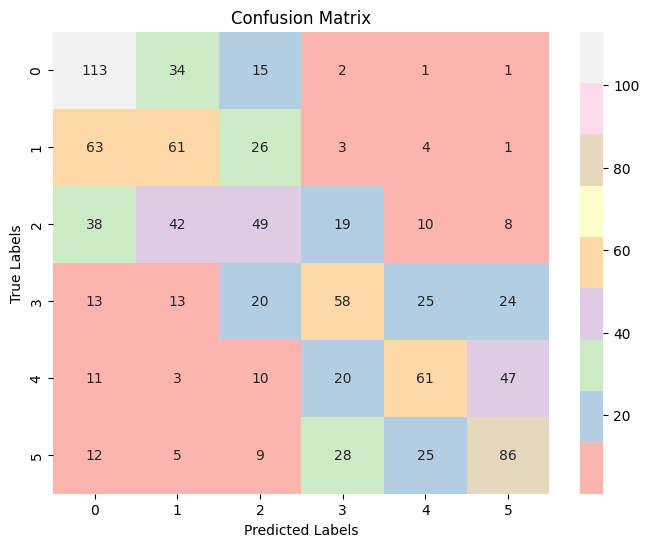

In [ ]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectors = tfidf_vectorizer.fit_transform(df['cleaned_text'])
tfidf_dense = np.array(tfidf_vectors.todense())  # Convert to dense array right after creation

# Tokenize text for Doc2Vec
df['tokenized_text'] = df['cleaned_text'].apply(str.split)

# Create tagged document objects
tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(df['tokenized_text'])]

# Initialize and train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=8, min_count=1, workers=4, alpha=0.025, min_alpha=0.00025, dm=0)
doc2vec_model.build_vocab(tagged_data)
epochs = 40
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=1)
    doc2vec_model.alpha -= (doc2vec_model.alpha - doc2vec_model.min_alpha) / epochs

# Infer vectors for each document
df['doc_vector'] = df['tokenized_text'].apply(lambda x: doc2vec_model.infer_vector(x))
doc_vectors = np.array(df['doc_vector'].tolist())

# Combine Doc2Vec and TF-IDF features
combined_features = np.hstack((doc_vectors, tfidf_dense))

# Prepare datasets for classification
y = df['difficulty'].values
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.2, random_state=42)

# Train a logistic regression classifier
#classifier = LogisticRegression(C=10, penalty='l1', solver='saga')
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

# Print results
print(f"Combined Features Accuracy: {accuracy}")
print("Confusion Matrix:")
print(cm)

# Plotting confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel1')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.68      0.54       166
           1       0.39      0.39      0.39       158
           2       0.38      0.30      0.33       166
           3       0.45      0.38      0.41       153
           4       0.48      0.40      0.44       152
           5       0.51      0.52      0.52       165

    accuracy                           0.45       960
   macro avg       0.44      0.44      0.44       960
weighted avg       0.44      0.45      0.44       960



In [ ]:
# Choose a word to find similar words
target_word = 'ville'

if target_word in doc2vec_model.wv.key_to_index:
    similar_words = doc2vec_model.wv.most_similar(target_word, topn=10)
    print("Similar Words to '{}':".format(target_word))
    for word, similarity in similar_words:
        print(f"{word}: {similarity:.4f}")
else:
    print("Word not found in the model's vocabulary.")

Similar Words to 'ville':
joindre: 0.3614
boulot: 0.3319
étreinte: 0.3240
etrangere: 0.3235
hont: 0.3165
accusation: 0.3097
dessine: 0.3097
expérimentation: 0.3068
tentant: 0.3044
dzinkowski: 0.3043


XGBoost model

Epoch 1 of 40
Epoch 2 of 40


Epoch 3 of 40


Epoch 4 of 40
Epoch 5 of 40


Epoch 6 of 40


Epoch 7 of 40


Epoch 8 of 40


Epoch 9 of 40


Epoch 10 of 40


Epoch 11 of 40


Epoch 12 of 40
Epoch 13 of 40


Epoch 14 of 40
Epoch 15 of 40


Epoch 16 of 40
Epoch 17 of 40


Epoch 18 of 40
Epoch 19 of 40


Epoch 20 of 40
Epoch 21 of 40


Epoch 22 of 40
Epoch 23 of 40


Epoch 24 of 40
Epoch 25 of 40


Epoch 26 of 40
Epoch 27 of 40


Epoch 28 of 40
Epoch 29 of 40


Epoch 30 of 40
Epoch 31 of 40


Epoch 32 of 40
Epoch 33 of 40


Epoch 34 of 40
Epoch 35 of 40


Epoch 36 of 40
Epoch 37 of 40


Epoch 38 of 40
Epoch 39 of 40


Epoch 40 of 40
Accuracy of the Doc2Vec + XGBoost model: 37.50%
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.58      0.54       166
           1       0.28      0.25      0.26       158
           2       0.28      0.26      0.27       166
           3       0.35      0.35      0.35       153
           4       0.37      0.42      0.40       152
           5       0.43      0.38      0.41       165

    accuracy                           0.38       960
   macro avg       0.37      0.37      0.37       960
weighted avg       0.37      0.38      0.37       960

Confusion Matrix:
[[97 40 24  2  1  2]
 [57 39 39 14  5  4]
 [25 36 43 24 19 19]
 [ 9 12 19 54 37 22]
 [ 3 10  9 30 64 36]
 [ 4  2 21 30 45 63]]


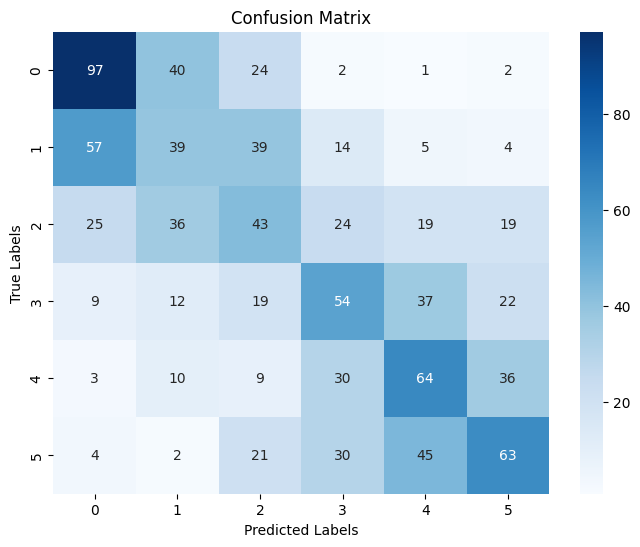

In [ ]:
df['cleaned_text'] = df['sentence'].apply(spacy_tokenizer)

# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectors = tfidf_vectorizer.fit_transform(df['cleaned_text'])
tfidf_dense = np.array(tfidf_vectors.todense())  # Convert to dense array right after creation

# Tokenize text for Doc2Vec
df['tokenized_text'] = df['cleaned_text'].apply(str.split)

# Create tagged document objects
tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(df['tokenized_text'])]

# Initialize and train the Doc2Vec model
doc2vec_model = Doc2Vec(vector_size=100, window=8, min_count=1, workers=4, alpha=0.025, min_alpha=0.00025, dm=0)
doc2vec_model.build_vocab(tagged_data)
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=1)
    doc2vec_model.alpha -= (doc2vec_model.alpha - doc2vec_model.min_alpha) / epochs

# Infer vectors for each document
df['doc_vector'] = df['tokenized_text'].apply(lambda x: doc2vec_model.infer_vector(x))
doc_vectors = np.array(df['doc_vector'].tolist())

# Combine Doc2Vec and TF-IDF features
combined_features = np.hstack((doc_vectors, tfidf_dense))

# Prepare datasets for classification
y = df['difficulty'].values
X_train, X_test, y_train, y_test = train_test_split(combined_features, y, test_size=0.2, random_state=42)

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Doc2Vec + XGBoost model: {accuracy * 100:.2f}%")

# Print the classification report for a detailed performance analysis
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix to see the classification breakdown
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Optionally, visualize the confusion matrix for better interpretation
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### Applying different prepcessing for the model to use the PV-DM

Epoch 1 of 100


Epoch 2 of 100


Epoch 3 of 100


Epoch 4 of 100


Epoch 5 of 100


Epoch 6 of 100


Epoch 7 of 100


Epoch 8 of 100


Epoch 9 of 100


Epoch 10 of 100


Epoch 11 of 100


Epoch 12 of 100


Epoch 13 of 100


Epoch 14 of 100


Epoch 15 of 100


Epoch 16 of 100


Epoch 17 of 100


Epoch 18 of 100


Epoch 19 of 100


Epoch 20 of 100


Epoch 21 of 100


Epoch 22 of 100


Epoch 23 of 100


Epoch 24 of 100


Epoch 25 of 100


Epoch 26 of 100


Epoch 27 of 100


Epoch 28 of 100


Epoch 29 of 100


Epoch 30 of 100


Epoch 31 of 100


Epoch 32 of 100


Epoch 33 of 100


Epoch 34 of 100


Epoch 35 of 100


Epoch 36 of 100


Epoch 37 of 100


Epoch 38 of 100


Epoch 39 of 100


Epoch 40 of 100


Epoch 41 of 100


Epoch 42 of 100


Epoch 43 of 100


Epoch 44 of 100


Epoch 45 of 100


Epoch 46 of 100


Epoch 47 of 100


Epoch 48 of 100


Epoch 49 of 100


Epoch 50 of 100


Epoch 51 of 100


Epoch 52 of 100


Epoch 53 of 100


Epoch 54 of 100


Epoch 55 of 100


Epoch 56 of 100


Epoch 57 of 100


Epoch 58 of 100


Epoch 59 of 100


Epoch 60 of 100


Epoch 61 of 100


Epoch 62 of 100


Epoch 63 of 100


Epoch 64 of 100


Epoch 65 of 100


Epoch 66 of 100


Epoch 67 of 100


Epoch 68 of 100


Epoch 69 of 100


Epoch 70 of 100


Epoch 71 of 100


Epoch 72 of 100


Epoch 73 of 100


Epoch 74 of 100


Epoch 75 of 100


Epoch 76 of 100


Epoch 77 of 100


Epoch 78 of 100


Epoch 79 of 100


Epoch 80 of 100


Epoch 81 of 100


Epoch 82 of 100


Epoch 83 of 100


Epoch 84 of 100


Epoch 85 of 100


Epoch 86 of 100


Epoch 87 of 100


Epoch 88 of 100


Epoch 89 of 100


Epoch 90 of 100


Epoch 91 of 100


Epoch 92 of 100


Epoch 93 of 100


Epoch 94 of 100


Epoch 95 of 100


Epoch 96 of 100


Epoch 97 of 100


Epoch 98 of 100


Epoch 99 of 100


Epoch 100 of 100
Accuracy: 0.25625
Confusion Matrix:
[[51 41 17 22 20 15]
 [41 40 17 20 22 18]
 [23 55 28 10 28 22]
 [16 30 14 22 32 39]
 [ 8 17 10 21 42 54]
 [17 24  9 16 36 63]]


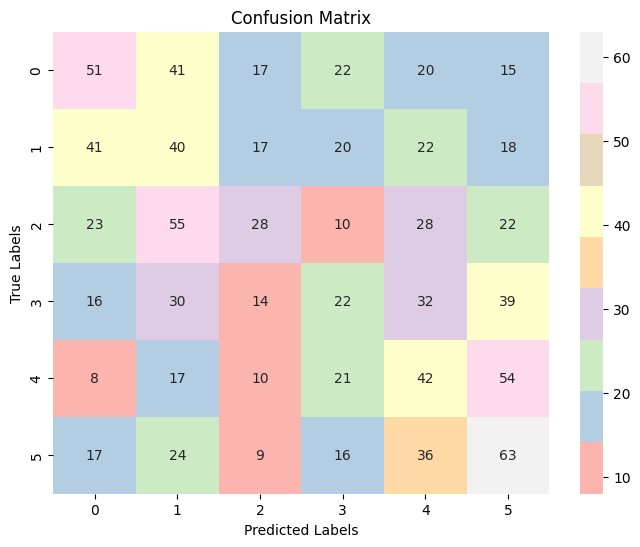

In [ ]:
# Define the tokenizer function for French text with less aggressive stopword removal
def spacy_tokenizer(sentence):
    punctuations = string.punctuation
    # Use a reduced set of stopwords to keep useful syntactic words
    minimal_stop_words = set(stopwords.words('french')) - set(['mais', 'ou', 'et', 'donc', 'or', 'ni', 'car'])

    mytokens = nlp(sentence)

    # Keeping pronouns and using light lemmatization
    mytokens = [word.lemma_ if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens]
    mytokens = [word for word in mytokens if word not in minimal_stop_words and word not in punctuations]

    return mytokens

# Assume df is your DataFrame and already loaded

label_encoder = LabelEncoder()
df['difficulty'] = label_encoder.fit_transform(df['difficulty'])

# Preprocess text data, tokenized but not converted back to string
df['tokenized_text'] = df['sentence'].apply(spacy_tokenizer)

# Create tagged document objects
tagged_data = [TaggedDocument(words=words, tags=[str(i)]) for i, words in enumerate(df['tokenized_text'])]

# Initialize the Doc2Vec model with dm=1
doc2vec_model = Doc2Vec(vector_size=200, window=5, min_count=1, workers=4, alpha=0.025, min_alpha=0.00025, dm=1)

# Build vocabulary from tagged data
doc2vec_model.build_vocab(tagged_data)

# Train the model
epochs = 100
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=1)
    doc2vec_model.alpha -= (doc2vec_model.alpha - doc2vec_model.min_alpha) / epochs

# Infer vectors for each document
df['doc_vector'] = df['tokenized_text'].apply(lambda x: doc2vec_model.infer_vector(x))

# Prepare datasets for classification
X = np.array(df['doc_vector'].tolist())
y = df['difficulty'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression(C=10, penalty='l2', solver='saga')
classifier.fit(X_train, y_train)

# Make predictions
predictions = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Pastel1')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### Word2VeC

[Word2Vec](https://medium.com/@manansuri/a-dummys-guide-to-word2vec-456444f3c673) creates a representation of each word present in our vocabulary into a vector. Words used in similar contexts or having semantic relationships are captured effectively through their closeness in the vector space- effectively speaking similar words will have similar word vectors



In [ ]:
# Tokenize the text to prepare for Word2Vec
#df['tokenized_text'] = df['sentence'].apply(spacy_tokenizer).apply(str.split)

In [ ]:
# Train the Word2Vec model on the tokenized text
w2v_model = Word2Vec(sentences=df['tokenized_text'], vector_size=200, window=5, min_count=1, workers=4)

In [ ]:
# Function to average word vectors for a document
def document_vector(model, doc):
    # Remove out-of-vocabulary words and compute average
    return np.mean([model.wv[word] for word in doc if word in model.wv], axis=0)

# Apply the function to each document
df['doc_vectors'] = df['tokenized_text'].apply(lambda doc: document_vector(w2v_model, doc))


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [ ]:
# Drop any rows with NaN values resulting from empty documents or those with all words out of the vocabulary
df = df.dropna(subset=['doc_vectors'])

X = np.array(df['doc_vectors'].tolist())
y = df['difficulty']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Initialize and train the logistic regression model
logistic_model = LogisticRegression(C=10, penalty='l2', solver='saga')
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Accuracy of the Word2Vec + Logistic Regression model: 19.12%
Classification Report:
              precision    recall  f1-score   support

          A1       0.23      0.46      0.31       158
          A2       0.38      0.03      0.05       182
          B1       0.00      0.00      0.00       174
          B2       0.00      0.00      0.00       163
          C1       0.00      0.00      0.00       151
          C2       0.17      0.81      0.28       129

    accuracy                           0.19       957
   macro avg       0.13      0.22      0.11       957
weighted avg       0.13      0.19      0.10       957

Confusion Matrix:
[[ 73   5   0   0   0  80]
 [ 97   5   0   0   0  80]
 [ 76   3   0   0   0  95]
 [ 28   0   0   0   0 135]
 [ 16   0   0   0   0 135]
 [ 24   0   0   0   0 105]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


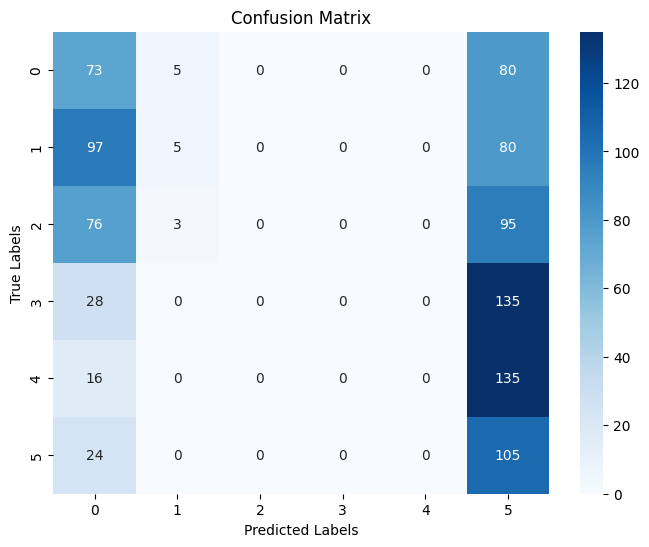

In [ ]:
# Make predictions
y_pred = logistic_model.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Word2Vec + Logistic Regression model: {accuracy * 100:.2f}%")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_mat)

# Optionally, visualize the confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

#### BERT

> [BERT](https://huggingface.co/blog/bert-101), short for Bidirectional Encoder Representations from Transformers, is a Machine Learning (ML) model for natural language processing

##### **Base BERT Model**:

In [ ]:
# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Function to tokenize text
def tokenize_data(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

# Apply the tokenizer to each sentence and extract the relevant tensors
input_ids = []
attention_masks = []

for sentence in df['sentence']:
    result = tokenize_data(sentence)
    input_ids.append(result['input_ids'].squeeze(0))
    attention_masks.append(result['attention_mask'].squeeze(0))

# Add tokenized data to the dataframe
df['input_ids'] = input_ids
df['attention_mask'] = attention_masks

# Prepare labels (ensure 'difficulty' column exists and is used correctly)
label_dict = {label: idx for idx, label in enumerate(df["difficulty"].unique())}
df['labels'] = df['difficulty'].map(label_dict)

# Split the dataset
train_df, val_df = train_test_split(df, test_size=0.1)
#train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['labels'])

# Dataset class for PyTorch
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.encodings = {'input_ids': dataframe['input_ids'].tolist(), 'attention_mask': dataframe['attention_mask'].tolist()}
        self.labels = dataframe['labels'].tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_df)
val_dataset = TextDataset(val_df)

# Load the BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=len(label_dict))

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01
)

# Metrics computation
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

# Evaluation and Confusion Matrix
eval_results = trainer.evaluate()
predictions = np.argmax(trainer.predict(val_dataset).predictions, axis=-1)
true_labels = [label['labels'].numpy() for label in val_dataset]

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### **BERT with Increased Sequence Length**

In [ ]:
# Initialize the BERT tokenizer with increased max length
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', model_max_length=256)

# Tokenization and encoding the dataset
def tokenize_data(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=256)

tokenized_data = df['sentence'].apply(tokenize_data)
df['input_ids'] = tokenized_data.apply(lambda x: x['input_ids'])
df['attention_mask'] = tokenized_data.apply(lambda x: x['attention_mask'])

# Prepare labels
label_dict = {label: idx for idx, label in enumerate(df["difficulty"].unique())}
df['labels'] = df['difficulty'].map(label_dict)

# Split the dataset
train_df, val_df = train_test_split(df, test_size=0.1)
#train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['labels'])

# Dataset class for PyTorch
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.encodings = {'input_ids': dataframe['input_ids'].tolist(), 'attention_mask': dataframe['attention_mask'].tolist()}
        self.labels = dataframe['labels'].tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_df)
val_dataset = TextDataset(val_df)

# Load the BERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', num_labels=len(label_dict))

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01
)

# Metrics computation
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

# Evaluation and Confusion Matrix
eval_results = trainer.evaluate()
predictions = np.argmax(trainer.predict(val_dataset).predictions, axis=-1)
true_labels = [label['labels'].numpy() for label in val_dataset]

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

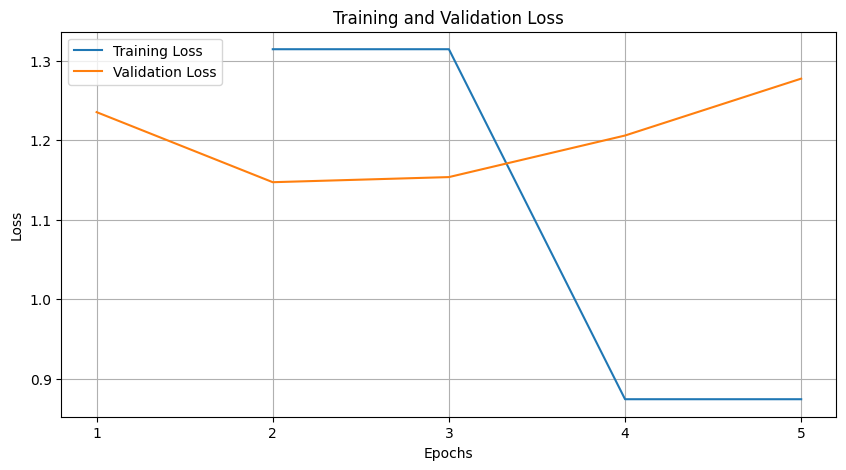

In [ ]:
# Define training and validation loss
training_loss = [None, 1.314300, 1.314300, 0.874100, 0.874100]  # None for 'No log'
validation_loss = [1.235162, 1.147047, 1.153481, 1.205762, 1.277318]

epochs = range(1, 6)

plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.legend()
plt.grid(True)
plt.show()

##### BERT Model with incresed sequence, noise droupout and warmup for the scheduler

In [ ]:
# Initialize the BERT tokenizer with increased max length
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', model_max_length=256)

# Tokenization and encoding the dataset
def tokenize_data(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=256)

tokenized_data = df['sentence'].apply(tokenize_data)
df['input_ids'] = tokenized_data.apply(lambda x: x['input_ids'])
df['attention_mask'] = tokenized_data.apply(lambda x: x['attention_mask'])

# Prepare labels
label_dict = {label: idx for idx, label in enumerate(df["difficulty"].unique())}
df['labels'] = df['difficulty'].map(label_dict)

# Split the dataset
train_df, val_df = train_test_split(df, test_size=0.1)
#train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['labels'])

# Dataset class for PyTorch
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.encodings = {'input_ids': dataframe['input_ids'].tolist(), 'attention_mask': dataframe['attention_mask'].tolist()}
        self.labels = dataframe['labels'].tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_df)
val_dataset = TextDataset(val_df)

# BERT configuration with adjusted dropout
config = BertConfig.from_pretrained('bert-base-cased', num_labels=len(label_dict), hidden_dropout_prob=0.2)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', config=config)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01
)

# Metrics computation using evaluate library
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Setup the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=training_args.learning_rate)

# Calculate the total number of training steps
num_training_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs

# Setup the scheduler with a warm-up phase
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),  # 10% of training steps as warm-up
    num_training_steps=num_training_steps
)

# Update Trainer with custom optimizer and scheduler
trainer.optimizer = optimizer
trainer.lr_scheduler = scheduler

# Start training with warm-up phase
trainer.train()

# Evaluation and Confusion Matrix
eval_results = trainer.evaluate()
predictions = np.argmax(trainer.predict(val_dataset).predictions, axis=-1)
true_labels = [label['labels'].numpy() for label in val_dataset]

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

Over sequence level 128

In [ ]:
# Initialize the BERT tokenizer with increased max length
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', model_max_length=128)

# Tokenization and encoding the dataset
def tokenize_data(text):
    return tokenizer(text, padding="max_length", truncation=True, max_length=128)

tokenized_data = df['sentence'].apply(tokenize_data)
df['input_ids'] = tokenized_data.apply(lambda x: x['input_ids'])
df['attention_mask'] = tokenized_data.apply(lambda x: x['attention_mask'])

# Prepare labels
label_dict = {label: idx for idx, label in enumerate(df["difficulty"].unique())}
df['labels'] = df['difficulty'].map(label_dict)

# Split the dataset
train_df, val_df = train_test_split(df, test_size=0.1)
#train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['labels'])

# Dataset class for PyTorch
class TextDataset(Dataset):
    def __init__(self, dataframe):
        self.encodings = {'input_ids': dataframe['input_ids'].tolist(), 'attention_mask': dataframe['attention_mask'].tolist()}
        self.labels = dataframe['labels'].tolist()

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_df)
val_dataset = TextDataset(val_df)

# BERT configuration with adjusted dropout
config = BertConfig.from_pretrained('bert-base-cased', num_labels=len(label_dict), hidden_dropout_prob=0.2)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-cased', config=config)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01
)

# Metrics computation using evaluate library
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='macro')
    precision = precision_score(labels, predictions, average='macro')
    recall = recall_score(labels, predictions, average='macro')
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# Setup the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=training_args.learning_rate)

# Calculate the total number of training steps
num_training_steps = len(train_dataset) // training_args.per_device_train_batch_size * training_args.num_train_epochs

# Setup the scheduler with a warm-up phase
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),  # 10% of training steps as warm-up
    num_training_steps=num_training_steps
)

# Update Trainer with custom optimizer and scheduler
trainer.optimizer = optimizer
trainer.lr_scheduler = scheduler

# Start training with warm-up phase
trainer.train()

# Evaluation and Confusion Matrix
eval_results = trainer.evaluate()
predictions = np.argmax(trainer.predict(val_dataset).predictions, axis=-1)
true_labels = [label['labels'].numpy() for label in val_dataset]

# Confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plotting the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()